# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Цели работы:**

-изучить данные компании «ГлавРосГосНефть»

-проанализировать данные

-обучить линейные модели машинного обучения для получения предсказания на валидации

-посчитайть риски и прибыль для каждого региона при помощи техники Bootstrap

**Описание данных:**

-Данные геологоразведки трёх регионов находятся в файлах: geo_data_0.csv, geo_data_1.csv, geo_data_2.csv

Данные состоят из:

id — уникальный идентификатор скважины

f0, f1, f2 — три признака точек (признаки значимы)

product — объём запасов в скважине (тыс. баррелей)

**Краткий план работы:**

-провести предобработку данных: устранить пропуски, дубликаты

-исследовать данные: найти закономерности, зависимости, визуализировать результаты

-обучить модели, получить предсказания

-рассчитать риски и прибыль для каждого региона

## Загрузка и подготовка данных

### Загрузка данных

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as st
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

Данные представленны в 3 файлах, прочитаем их и сохраним

In [ ]:
df_geo1 = pd.read_csv('/datasets/geo_data_0.csv', sep = ',')
df_geo2 = pd.read_csv('/datasets/geo_data_1.csv', sep = ',')
df_geo3 = pd.read_csv('/datasets/geo_data_2.csv', sep = ',')

In [ ]:
df_geo1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [ ]:
df_geo1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [ ]:
df_geo2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [ ]:
df_geo2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [ ]:
df_geo3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [ ]:
df_geo3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Во всех таблицах (каждая отдельный регион) 100000 строк:

1 колонка типа object: id;

3 колонки типа float: f0, f1, f2, product

### Предобработка данных

#### Пропуски и дубликаты

Проверим наличие пропусков в данных

In [ ]:
df_geo1.isna().mean()

id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64

In [ ]:
df_geo2.isna().mean()

id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64

In [ ]:
df_geo3.isna().mean()

id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64

Пропусков не обнаружено

Проверим дубликаты в данных

In [ ]:
df_geo1.duplicated().sum()

0

In [ ]:
df_geo2.duplicated().sum()

0

In [ ]:
df_geo3.duplicated().sum()

0

Явных дубликатов нет

Проверим дубликаты по 'id'

In [ ]:
df_geo1['id'].duplicated().sum()

10

In [ ]:
df_geo1[df_geo1['id'].duplicated() == True]

,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
66136,74z30,1.084962,-0.312358,6.990771,127.643327
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964018
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


Проверим дубликаты исключая 'id'

In [ ]:
df_geo1.drop('id', axis=1).duplicated().sum()

0

Таковых нет, выходит у нас есть одни и те же скважины но с разными параметрами

In [ ]:
df_geo1[(df_geo1['id'] == 'HZww2') | (df_geo1['id'] == 'bxg6G') | (df_geo1['id'] == 'A5aEY') |
        (df_geo1['id'] == 'QcMuo') | (df_geo1['id'] == '74z30') | (df_geo1['id'] == 'AGS9W') |
        (df_geo1['id'] == 'Tdehs') | (df_geo1['id'] == 'fiKDv') | (df_geo1['id'] == 'TtcGQ') |
        (df_geo1['id'] == 'bsk9y')]

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


Исключать их не буду, ибо не знаю какие параметры правильные

In [ ]:
df_geo2['id'].duplicated().sum()

4

In [ ]:
df_geo2[df_geo2['id'].duplicated() == True]

,id,f0,f1,f2,product
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


In [ ]:
df_geo2.drop('id', axis=1).duplicated().sum()

0

In [ ]:
df_geo2[(df_geo2['id'] == 'LHZR0') | (df_geo2['id'] == 'bfPNe') | (df_geo2['id'] == 'wt4Uk') |
        (df_geo2['id'] == '5ltQ6')]

,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


In [ ]:
df_geo3['id'].duplicated().sum()

4

In [ ]:
df_geo3[df_geo3['id'].duplicated() == True]

,id,f0,f1,f2,product
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


In [ ]:
df_geo3.drop('id', axis=1).duplicated().sum()

0

In [ ]:
df_geo3[(df_geo3['id'] == 'xCHr8') | (df_geo3['id'] == 'VF7Jo') | (df_geo3['id'] == 'uxKUPhWqyU') |
        (df_geo3['id'] == 'Vcm5J')]

,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


Наблюдаем идентичную ситуацию с разными параметрами на одних и тех же скважинах

### Исследовательский анализ данных

#### 1-ый регион

Создадим функцию и выделим категории из целевого признака, для дальнейшей цветовой маркировки на гистограммах в целях визуализации закономерностей на кол-ых признаках

In [ ]:
df_geo1['product_cat'] = pd.qcut(df_geo1['product'], 3)
def product_cat(row):
    if row == df_geo1['product_cat'].unique().min():
        return 'low'
    elif row == df_geo1['product_cat'].unique().max():
        return 'high'
    else:
        return 'medium'
df_geo1['product_cat'] = df_geo1['product_cat'].apply(product_cat)
df_geo1['product_cat'].head()

0    medium
1    medium
2    medium
3      high
4      high
Name: product_cat, dtype: category
Categories (3, object): ['low' < 'medium' < 'high']

In [ ]:
df_geo1.head()

,id,f0,f1,f2,product,product_cat
0,txEyH,0.705745,-0.497823,1.221170,105.280062,medium
1,2acmU,1.334711,-0.340164,4.365080,73.037750,medium
2,409Wp,1.022732,0.151990,1.419926,85.265647,medium
3,iJLyR,-0.032172,0.139033,2.978566,168.620776,high
4,Xdl7t,1.988431,0.155413,4.751769,154.036647,high


f0
count    100000.000000
mean          0.500419
std           0.871832
min          -1.408605
25%          -0.072580
50%           0.502360
75%           1.073581
max           2.362331
Name: f0, dtype: float64


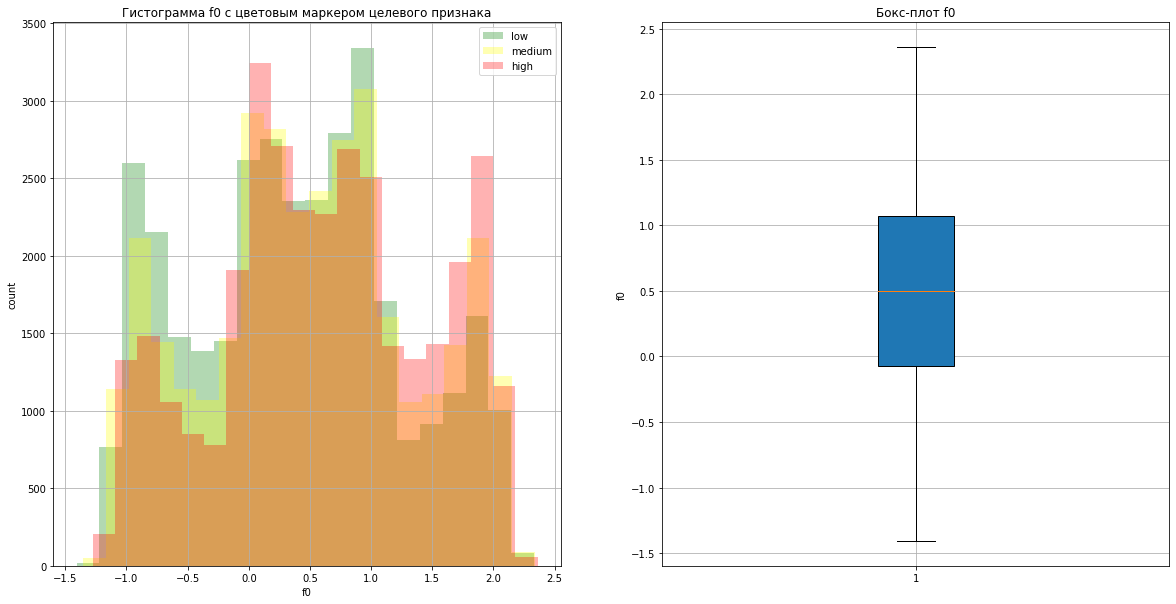

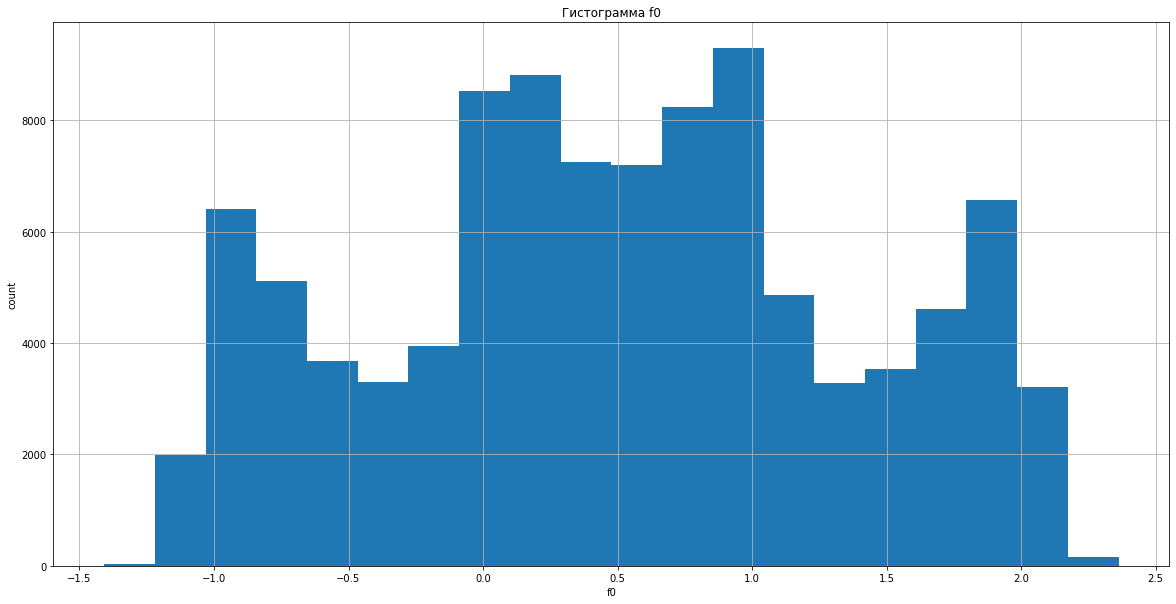

f1
count    100000.000000
mean          0.250143
std           0.504433
min          -0.848218
25%          -0.200881
50%           0.250252
75%           0.700646
max           1.343769
Name: f1, dtype: float64


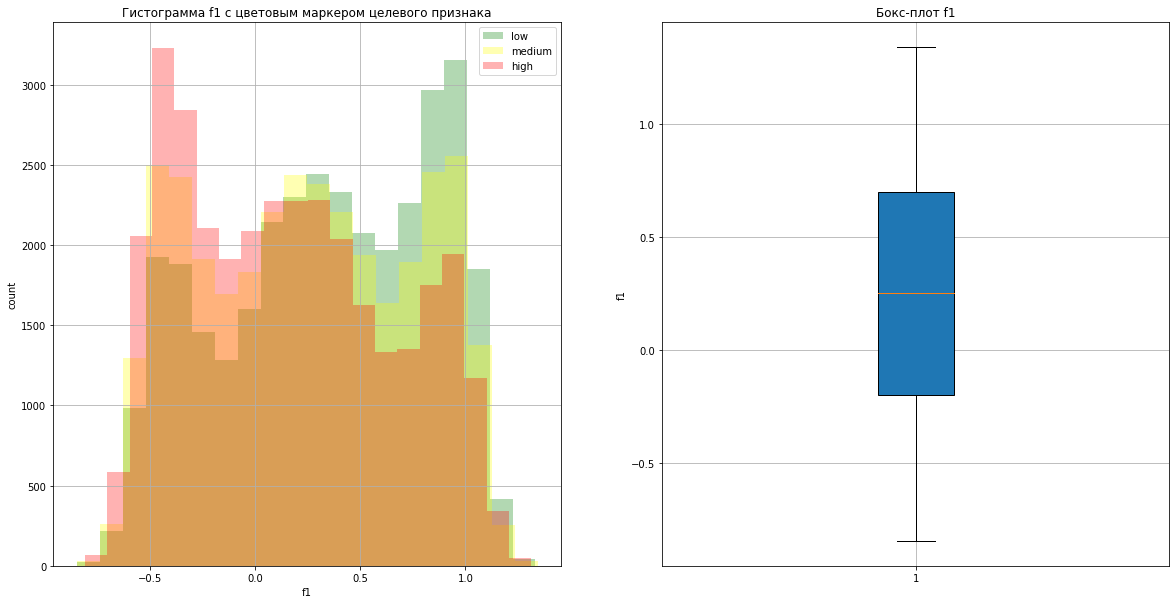

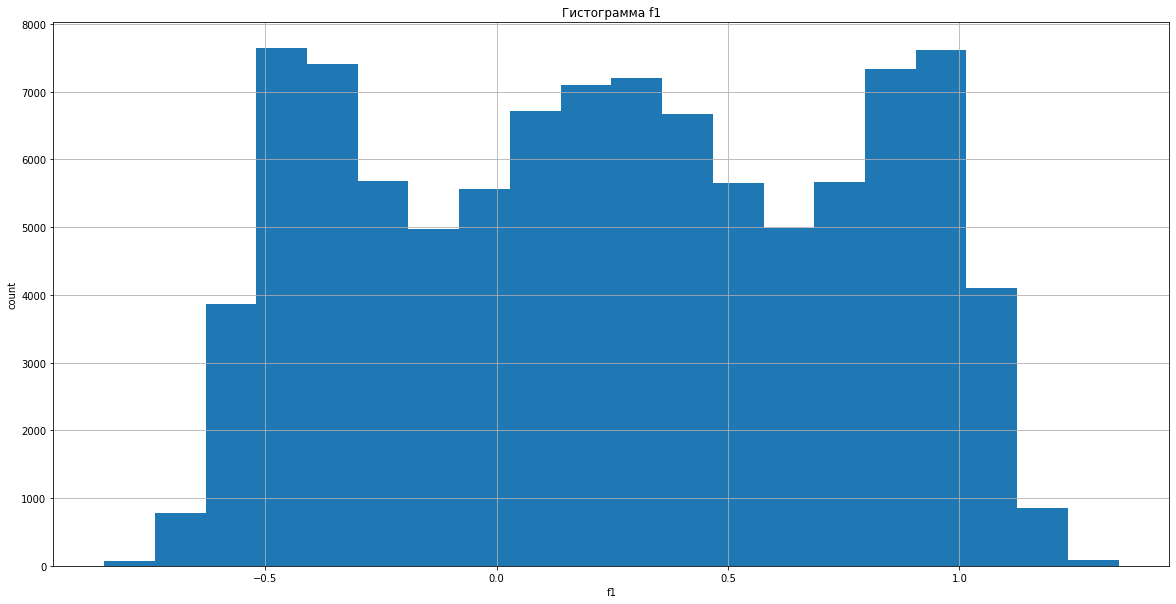

f2
count    100000.000000
mean          2.502647
std           3.248248
min         -12.088328
25%           0.287748
50%           2.515969
75%           4.715088
max          16.003790
Name: f2, dtype: float64


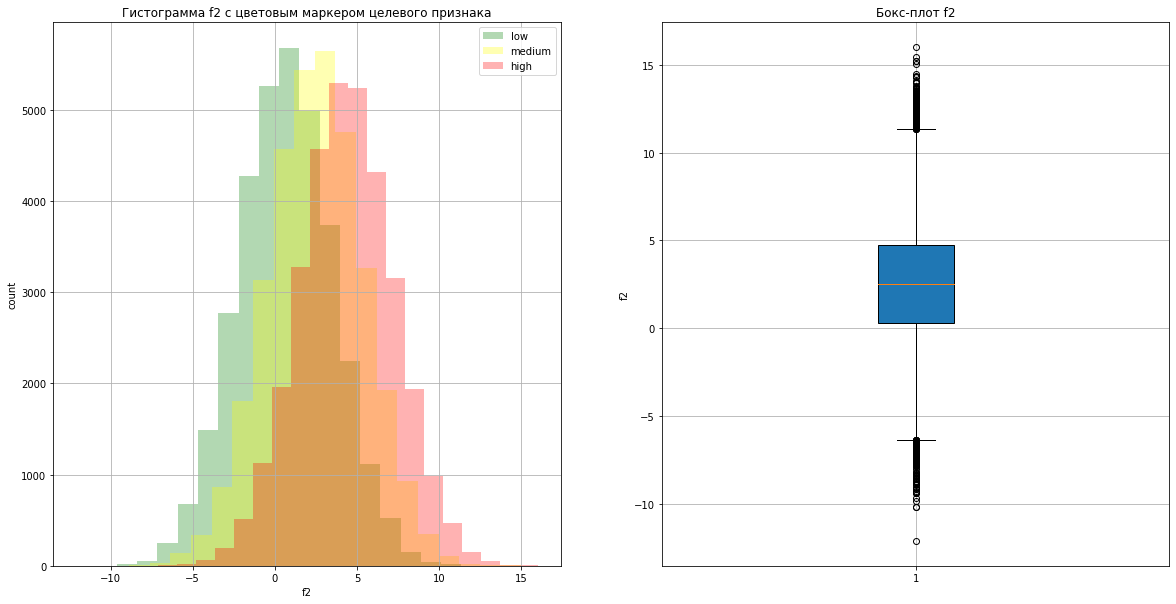

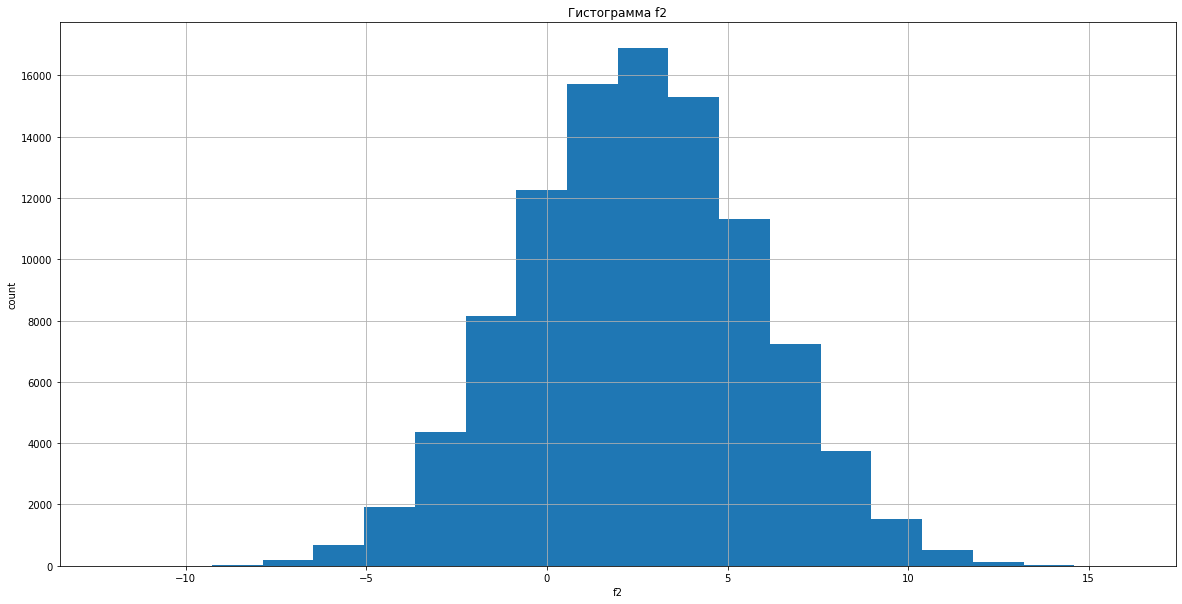

product
count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64


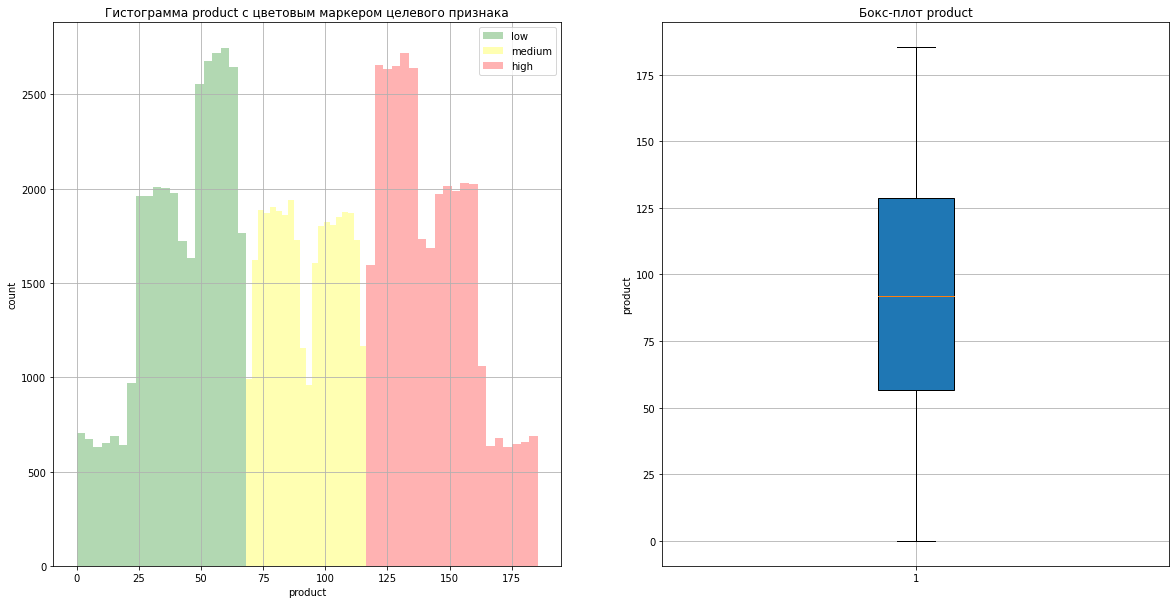

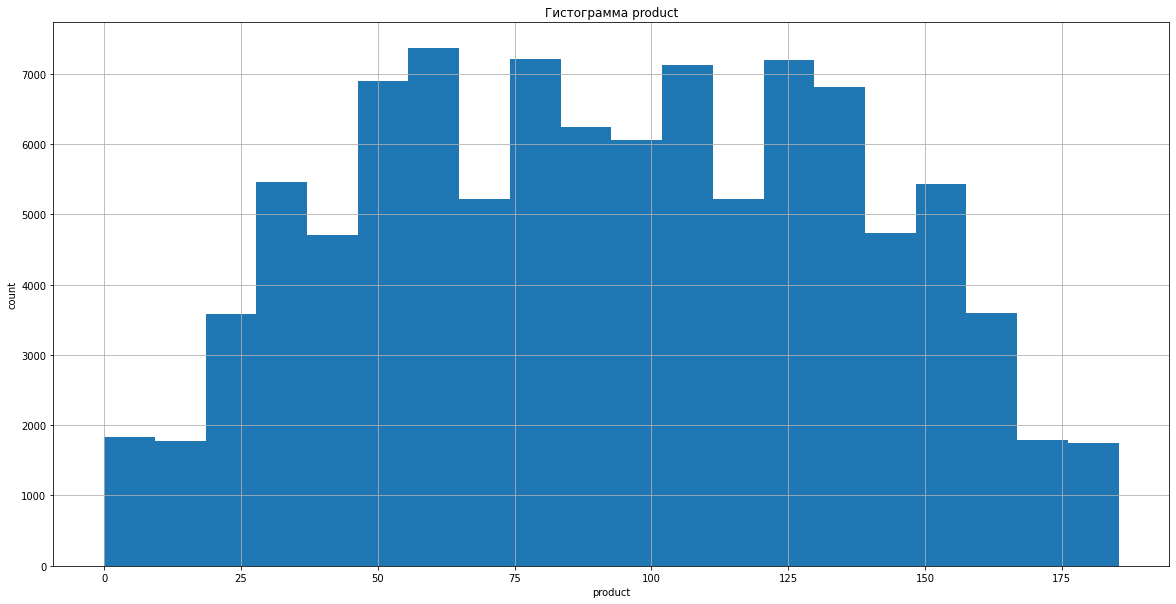

In [ ]:
for colum in ['f0', 'f1', 'f2', 'product']:
    print(colum)
    print(df_geo1[colum].describe())
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    for color, row in (['green', 'low'],
                       ['yellow', 'medium'],
                       ['red', 'high']):
        x = df_geo1[df_geo1['product_cat'] == row][colum]
        ax[0].hist(x, bins=20, color=color, alpha=0.3, label=row)

    ax[0].set_xlabel(colum)
    ax[0].set_ylabel('count')
    ax[0].legend(loc="best")
    ax[0].set_title('Гистограмма ' + colum + ' с цветовым маркером целевого признака')
    ax[0].grid(True)

    ax[1].boxplot(df_geo1[colum], patch_artist=True)
    ax[1].set_ylabel(colum)
    ax[1].set_title('Бокс-плот ' + colum)
    ax[1].grid(True)
    plt.show()

    fig, ax = plt.subplots(figsize=(20, 10))
    x = df_geo1[colum]
    plt.hist(x, bins=20)
    plt.title('Гистограмма ' + colum)
    plt.xlabel(colum)
    plt.ylabel('count')
    plt.grid(True)
    plt.show()

-**'f0'** напоминает нормальное распределение с 'пиками' ближе к крайним значениям разброс варьируется от -1.4 до 2.36, в среднем 0.5

Цветовой маркер целевого признака указывает что 'f0' чуть меньше у скважины с малым содержанием продукта

Аномальных значений не наблюдаем

-**'f1'** напоминает нормальное распределение разброс варьируется от -0.8 до 1.34, в среднем 0.25

Цветовой маркер целевого признака указывает что 'f1' чуть больше у скважины с малым содержанием продукта

Аномальных значений не наблюдаем

-**'f2'** напоминает нормальное распределение разброс варьируется от -12.08 до 16, в среднем 2.5

Цветовой маркер целевого признака указывает что 'f2' больше у скважины с большим содержанием продукта

Наблюдаем слегка выбивающиеся значения с обоих сторон распределения

-**'product'**(объём запасов в скважине, целевой признак) напоминает нормальное распределение разброс продукта варьируется от 0 до 185, в среднем 92.5

Аномальных значений не наблюдаем

#### 2-ой регион

In [ ]:
df_geo2['product_cat'] = pd.qcut(df_geo2['product'], 3)
def product_cat(row):
    if row == df_geo2['product_cat'].unique().min():
        return 'low'
    elif row == df_geo2['product_cat'].unique().max():
        return 'high'
    else:
        return 'medium'
df_geo2['product_cat'] = df_geo2['product_cat'].apply(product_cat)
df_geo2['product_cat'].head()

0     low
1     low
2    high
3    high
4    high
Name: product_cat, dtype: category
Categories (3, object): ['low' < 'medium' < 'high']

In [ ]:
df_geo2.head()

,id,f0,f1,f2,product,product_cat
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103,low
1,62mP7,14.272088,-3.475083,0.999183,26.953261,low
2,vyE1P,6.263187,-5.948386,5.001160,134.766305,high
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408,high
4,AHL4O,12.702195,-8.147433,5.004363,134.766305,high


f0
count    100000.000000
mean          1.141296
std           8.965932
min         -31.609576
25%          -6.298551
50%           1.153055
75%           8.621015
max          29.421755
Name: f0, dtype: float64


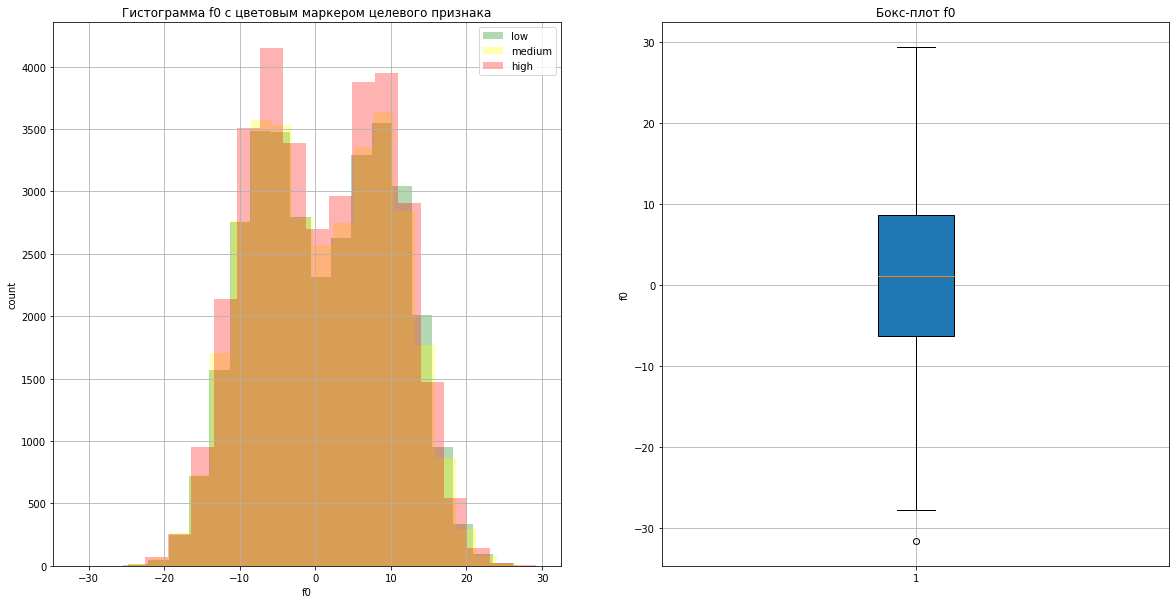

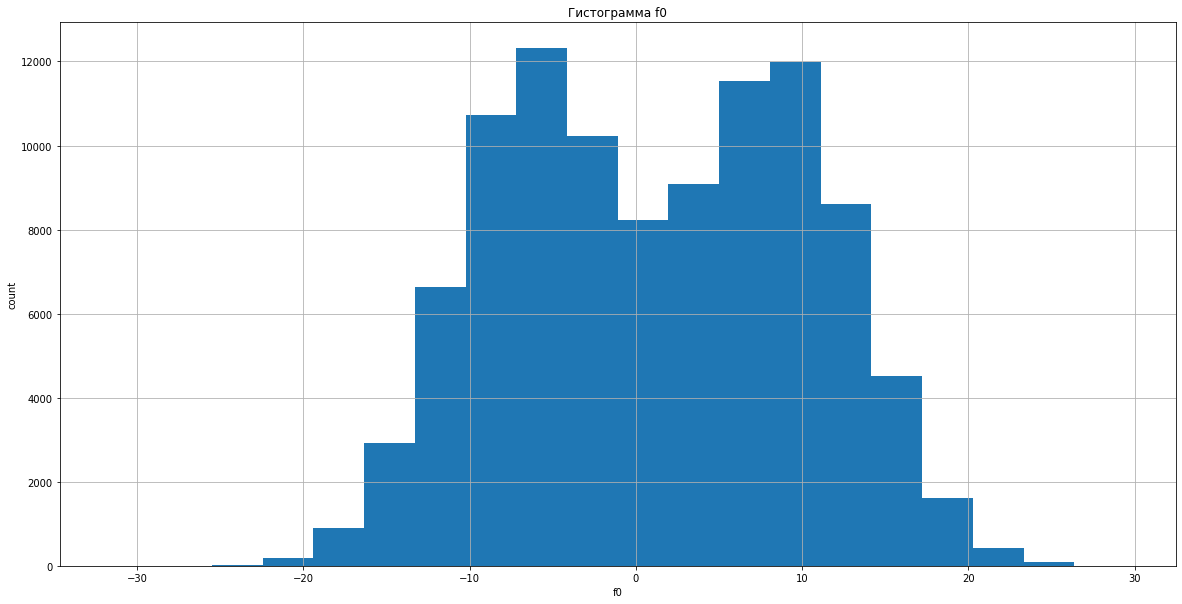

f1
count    100000.000000
mean         -4.796579
std           5.119872
min         -26.358598
25%          -8.267985
50%          -4.813172
75%          -1.332816
max          18.734063
Name: f1, dtype: float64


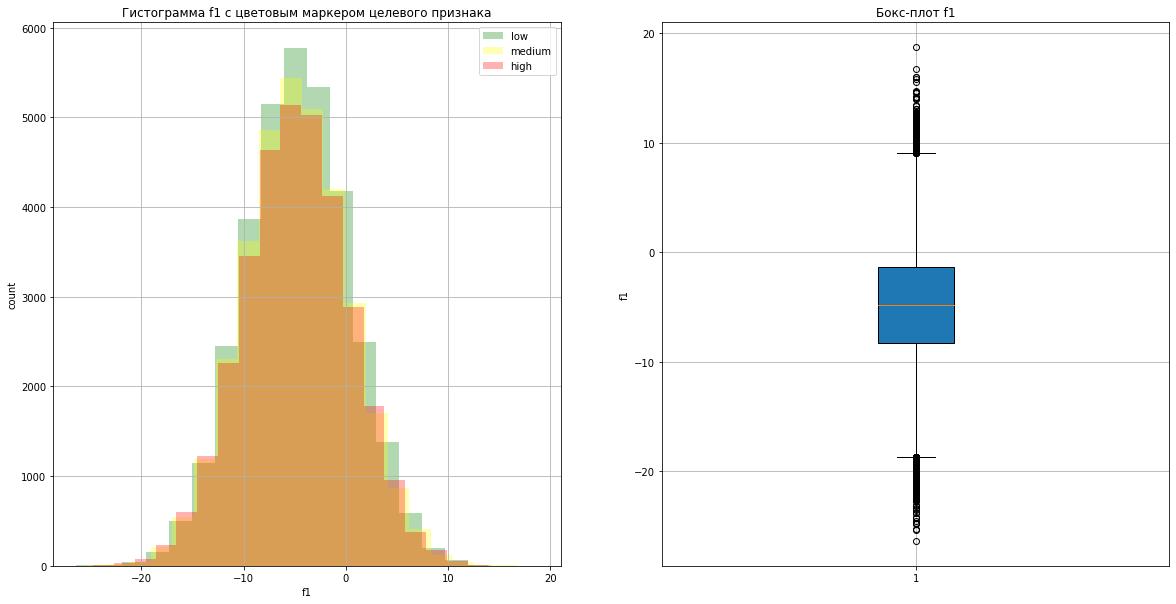

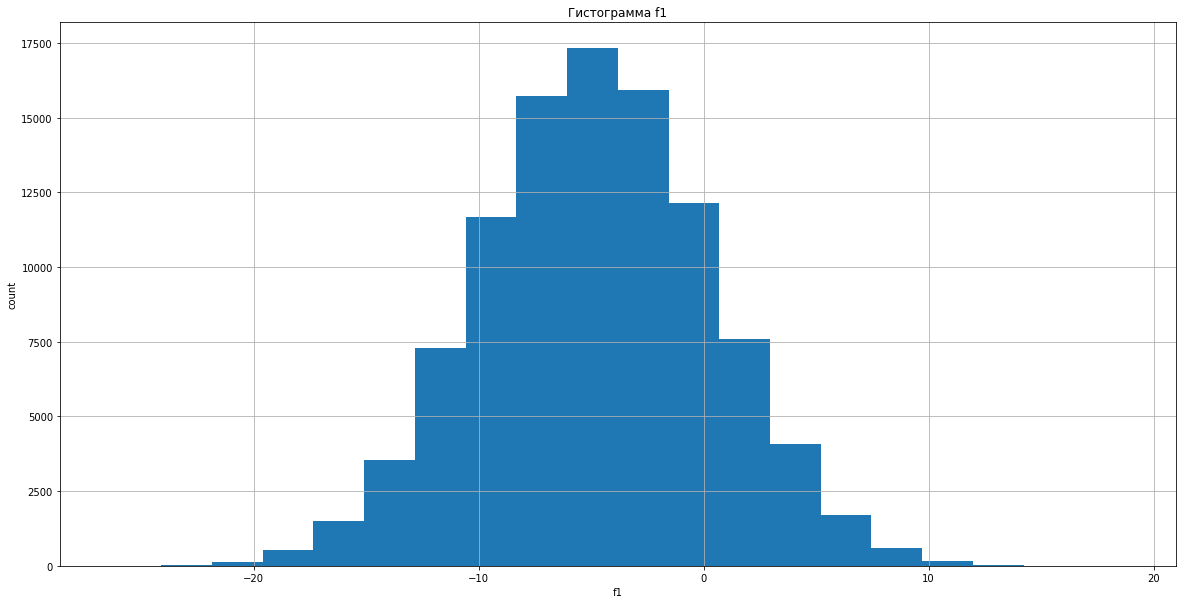

f2
count    100000.000000
mean          2.494541
std           1.703572
min          -0.018144
25%           1.000021
50%           2.011479
75%           3.999904
max           5.019721
Name: f2, dtype: float64


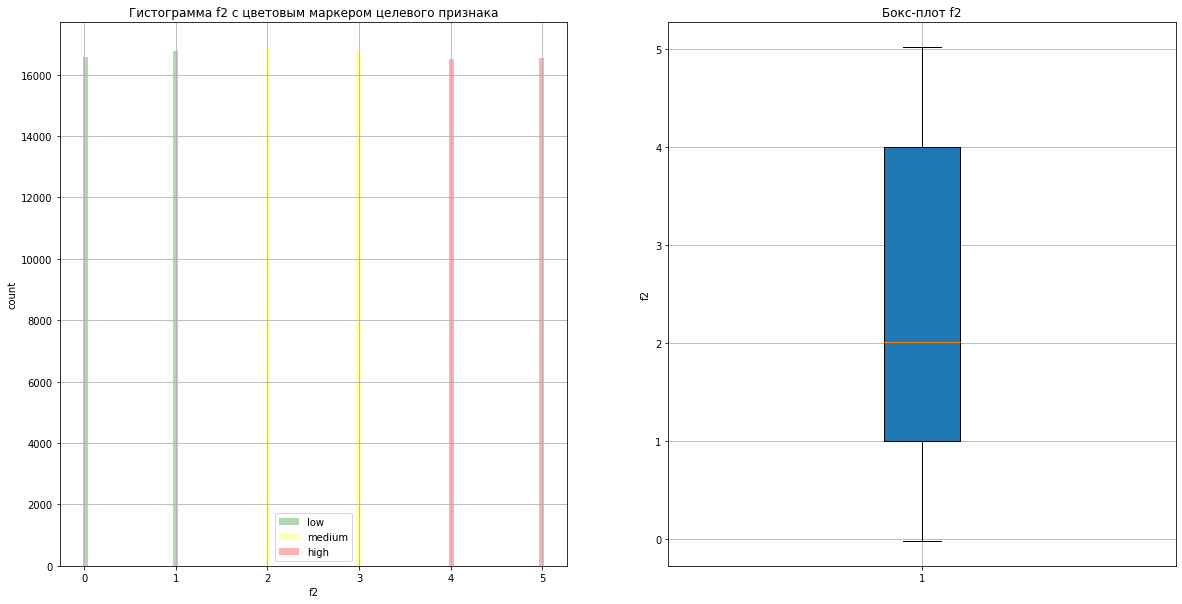

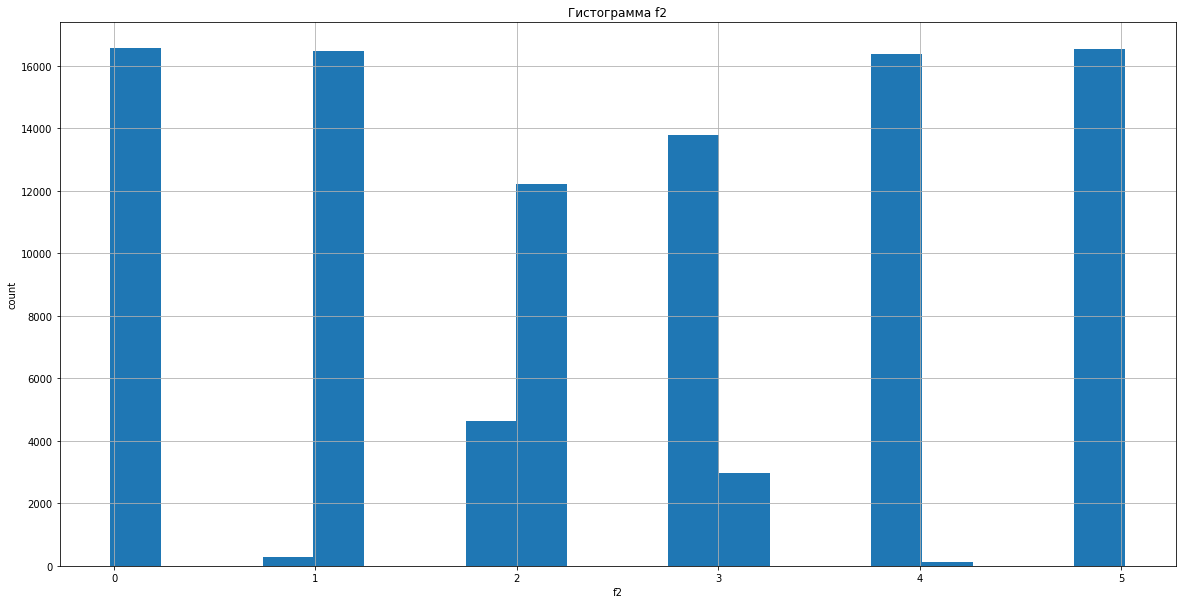

product
count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64


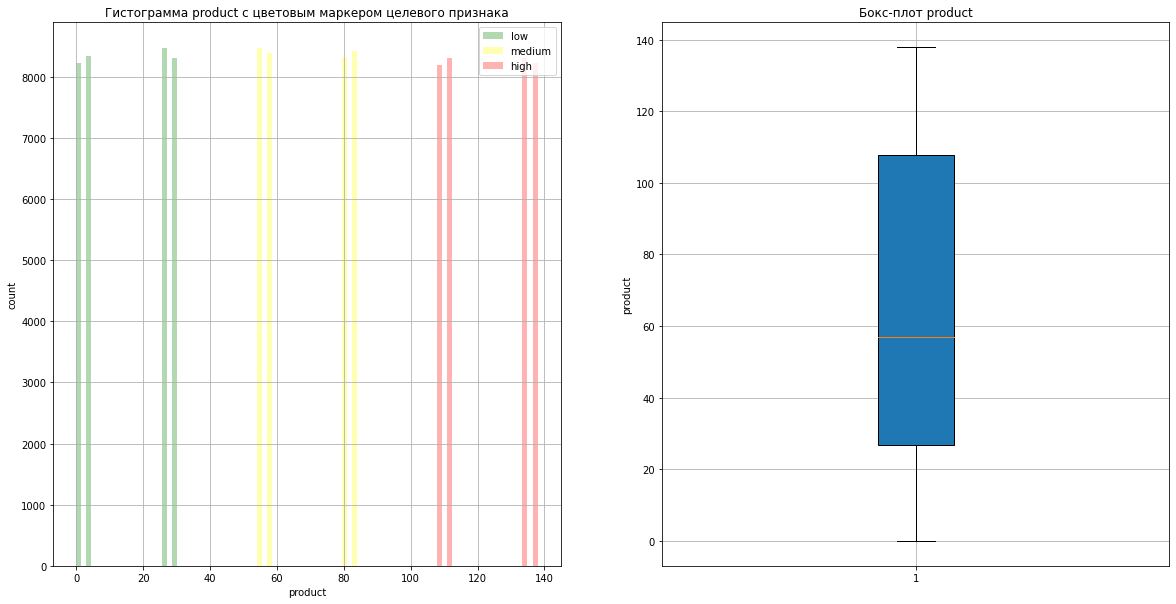

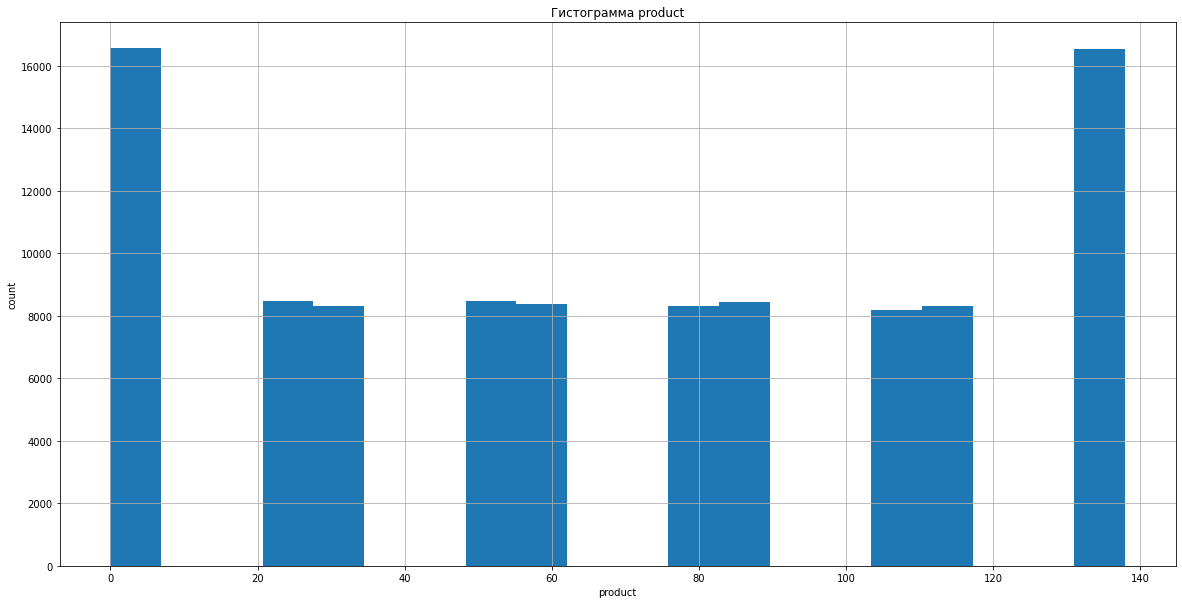

In [ ]:
for colum in ['f0', 'f1', 'f2', 'product']:
    print(colum)
    print(df_geo2[colum].describe())
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    for color, row in (['green', 'low'],
                       ['yellow', 'medium'],
                       ['red', 'high']):
        x = df_geo2[df_geo2['product_cat'] == row][colum]
        ax[0].hist(x, bins=20, color=color, alpha=0.3, label=row)

    ax[0].set_xlabel(colum)
    ax[0].set_ylabel('count')
    ax[0].legend(loc="best")
    ax[0].set_title('Гистограмма ' + colum + ' с цветовым маркером целевого признака')
    ax[0].grid(True)

    ax[1].boxplot(df_geo2[colum], patch_artist=True)
    ax[1].set_ylabel(colum)
    ax[1].set_title('Бокс-плот ' + colum)
    ax[1].grid(True)
    plt.show()

    fig, ax = plt.subplots(figsize=(20, 10))
    x = df_geo2[colum]
    plt.hist(x, bins=20)
    plt.title('Гистограмма ' + colum)
    plt.xlabel(colum)
    plt.ylabel('count')
    plt.grid(True)
    plt.show()

-**'f0'** напоминает нормальное распределение разброс варьируется от -31.6 до 29.42, в среднем 1.14

Цветовой маркер целевого признака случаен

Аномальных значений не наблюдаем

-**'f1'** напоминает нормальное распределение разброс варьируется от -26.35 до 18.73, в среднем -4.79

Цветовой маркер целевого признака случаен

Наблюдаем слегка выбивающиеся значения с обоих сторон распределения

-**'f2'** имеет вид распределения Бернули с 6-ю вариантами событий, большенство наблюдений расположенны около целых значений что аномально, разброс варьируется от -0.01 до 5.01 в среднем 2.49

Цветовой маркер целевого признака указывает что 'f2' больше у скважины с большим содержанием продукта

Аномальных значений не наблюдаем

-**'product'**(объём запасов в скважине, целевой признак) имеет одентичный вид с 'f2', разброс варьируется от 0 до 137.9 в среднем 68.82

Аномальных значений не наблюдаем

#### 3-ий регион

In [ ]:
df_geo3['product_cat'] = pd.qcut(df_geo3['product'], 3)
def product_cat(row):
    if row == df_geo3['product_cat'].unique().min():
        return 'low'
    elif row == df_geo3['product_cat'].unique().max():
        return 'high'
    else:
        return 'medium'
df_geo3['product_cat'] = df_geo3['product_cat'].apply(product_cat)
df_geo3['product_cat'].head()

0       low
1       low
2       low
3    medium
4      high
Name: product_cat, dtype: category
Categories (3, object): ['low' < 'medium' < 'high']

In [ ]:
df_geo3.head()

,id,f0,f1,f2,product,product_cat
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673,low
1,WJtFt,0.262778,0.269839,-2.530187,56.069697,low
2,ovLUW,0.194587,0.289035,-5.586433,62.871910,low
3,q6cA6,2.236060,-0.553760,0.930038,114.572842,medium
4,WPMUX,-0.515993,1.716266,5.899011,149.600746,high


f0
count    100000.000000
mean          0.002023
std           1.732045
min          -8.760004
25%          -1.162288
50%           0.009424
75%           1.158535
max           7.238262
Name: f0, dtype: float64


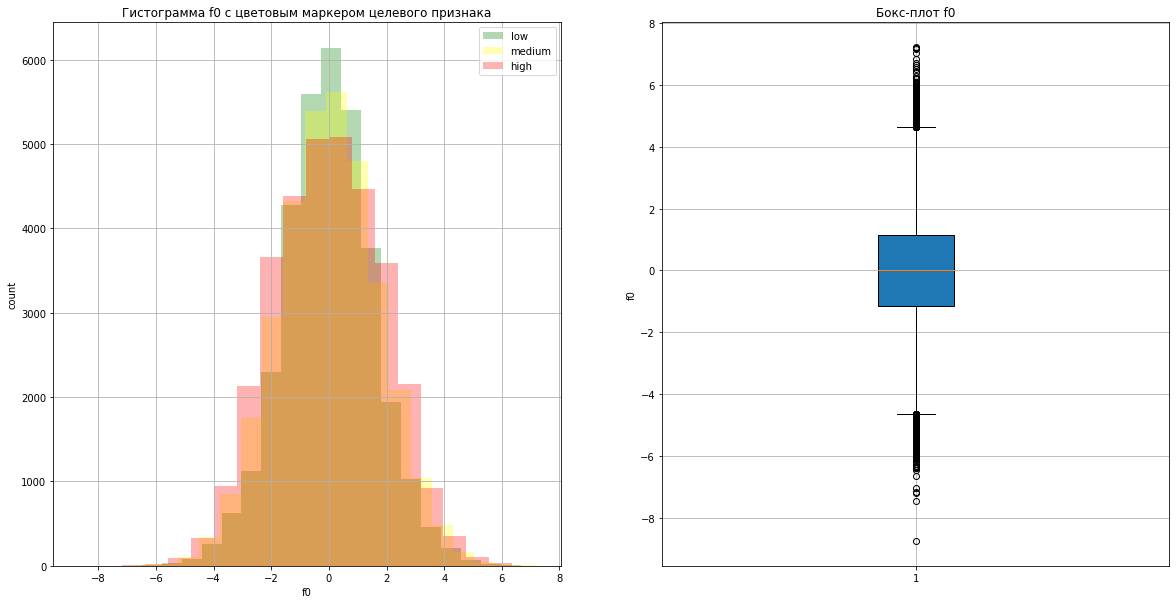

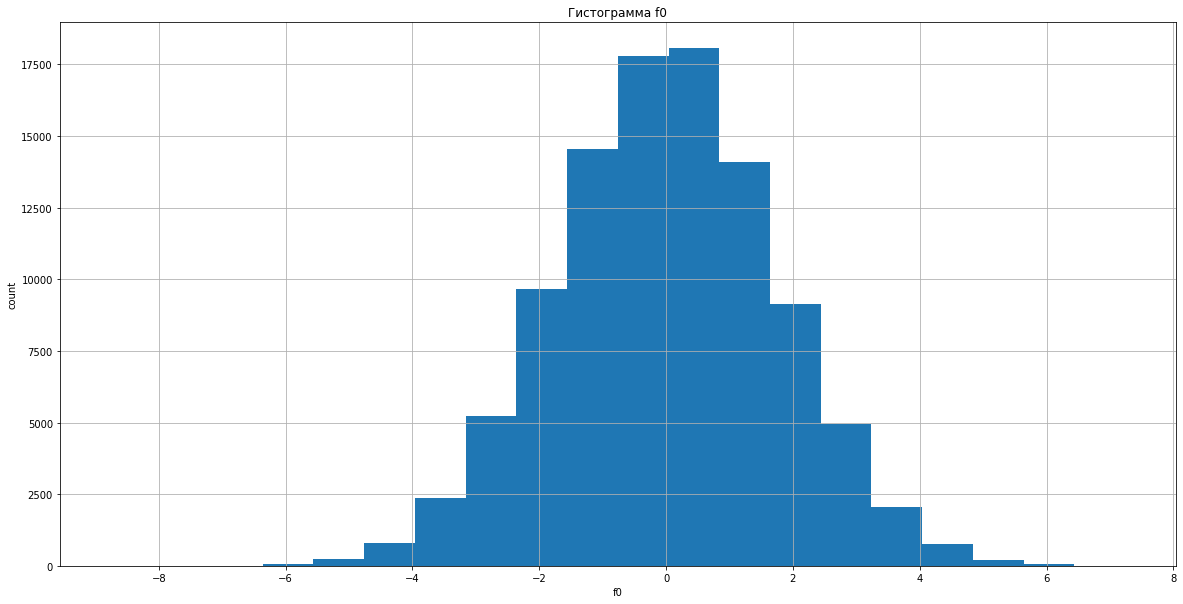

f1
count    100000.000000
mean         -0.002081
std           1.730417
min          -7.084020
25%          -1.174820
50%          -0.009482
75%           1.163678
max           7.844801
Name: f1, dtype: float64


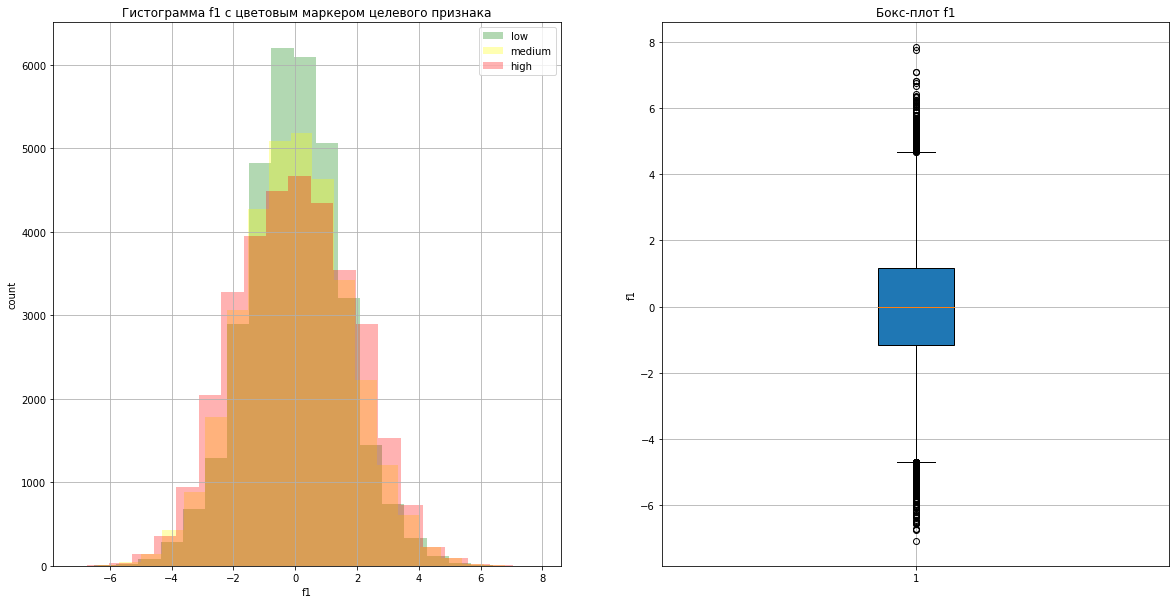

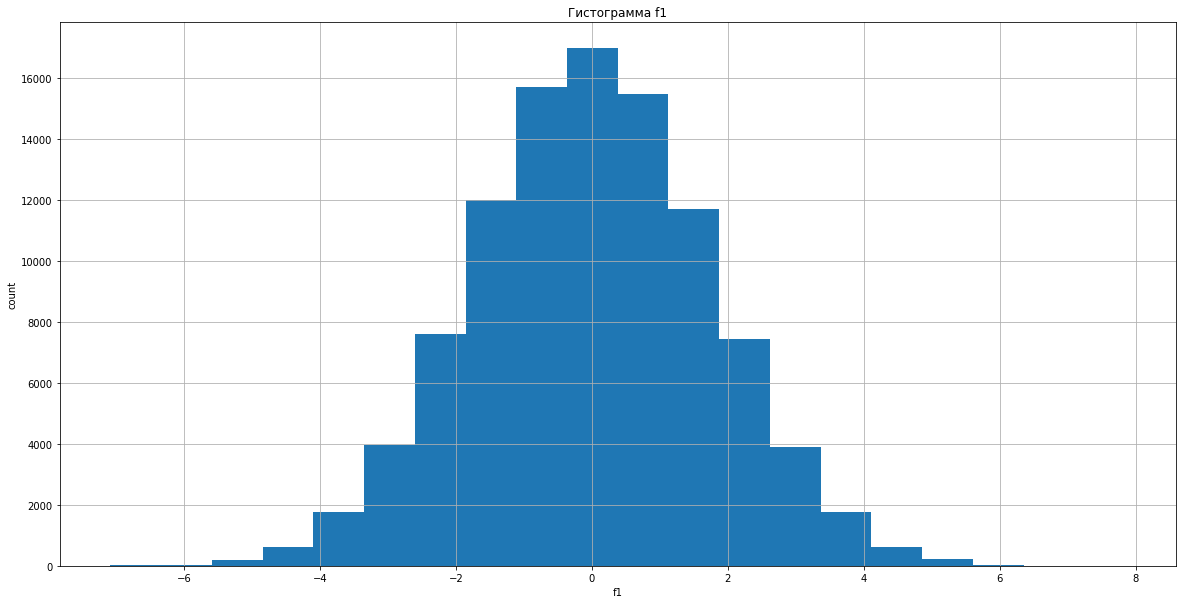

f2
count    100000.000000
mean          2.495128
std           3.473445
min         -11.970335
25%           0.130359
50%           2.484236
75%           4.858794
max          16.739402
Name: f2, dtype: float64


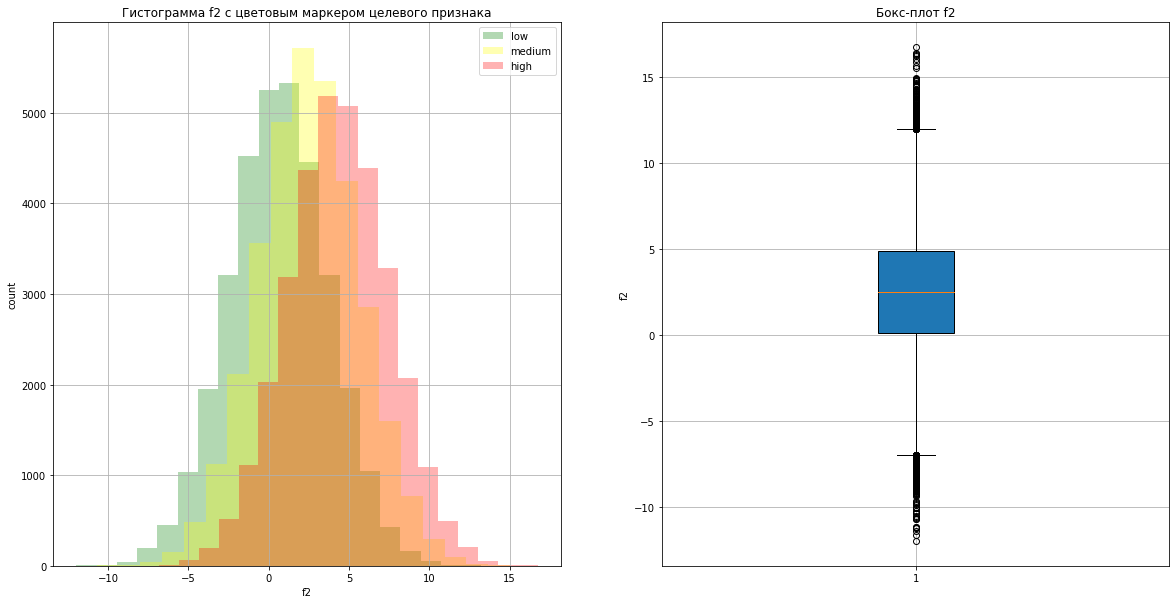

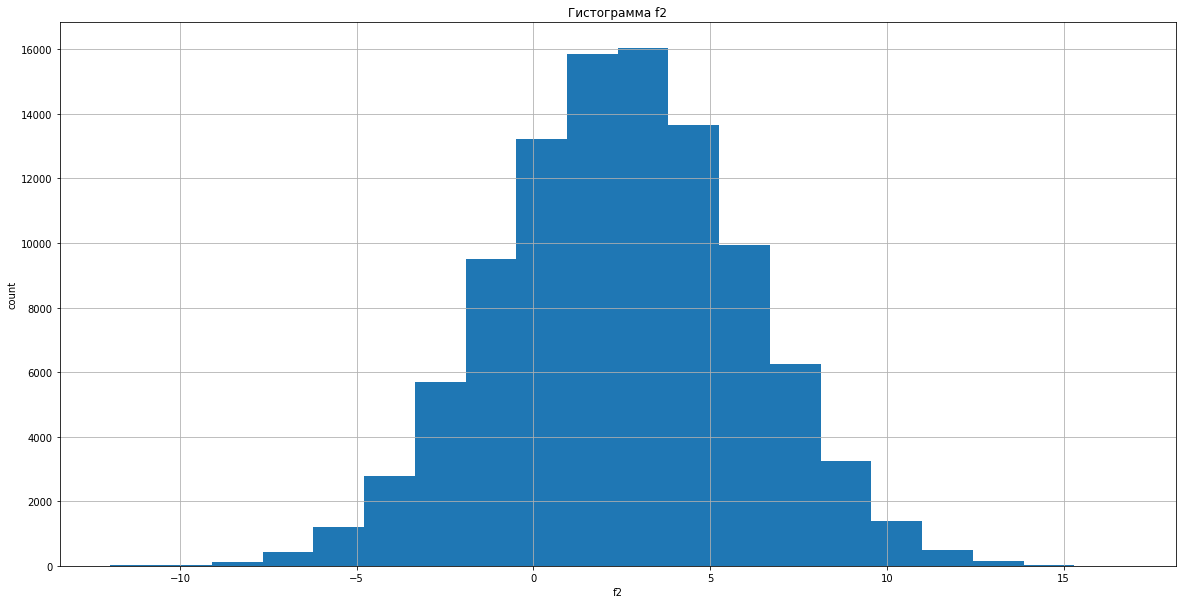

product
count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64


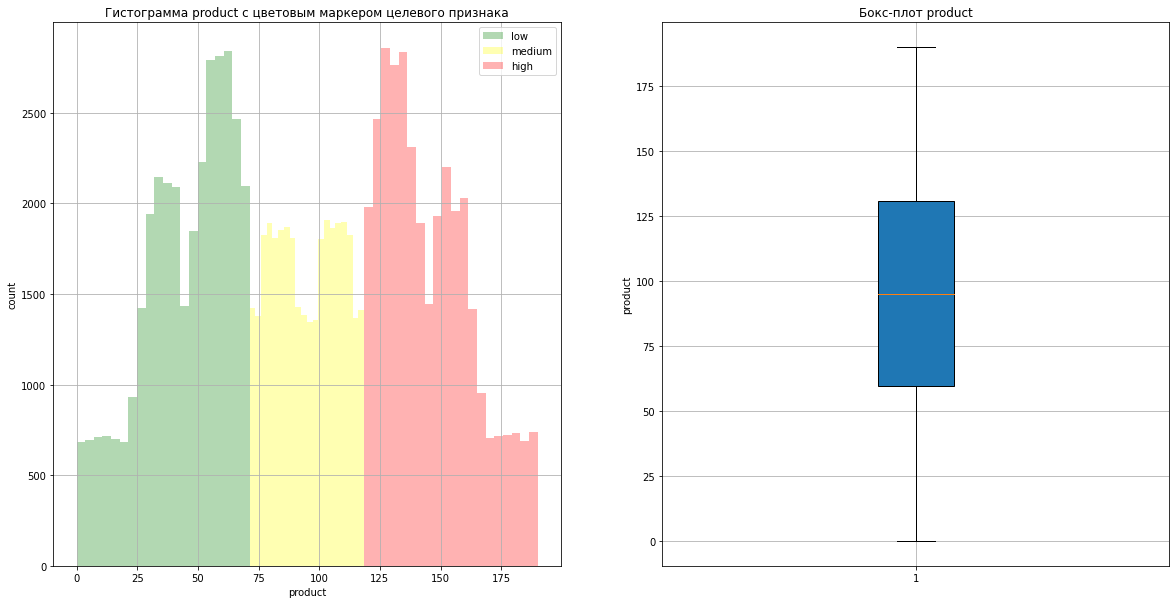

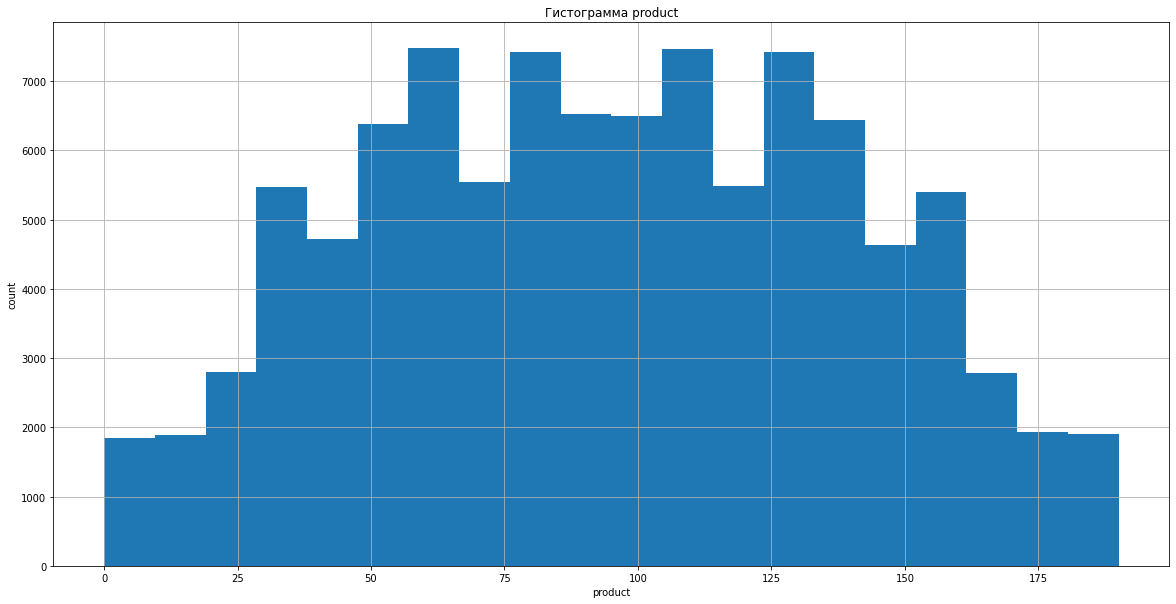

In [ ]:
for colum in ['f0', 'f1', 'f2', 'product']:
    print(colum)
    print(df_geo3[colum].describe())
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    for color, row in (['green', 'low'],
                       ['yellow', 'medium'],
                       ['red', 'high']):
        x = df_geo3[df_geo3['product_cat'] == row][colum]
        ax[0].hist(x, bins=20, color=color, alpha=0.3, label=row)

    ax[0].set_xlabel(colum)
    ax[0].set_ylabel('count')
    ax[0].legend(loc="best")
    ax[0].set_title('Гистограмма ' + colum + ' с цветовым маркером целевого признака')
    ax[0].grid(True)

    ax[1].boxplot(df_geo3[colum], patch_artist=True)
    ax[1].set_ylabel(colum)
    ax[1].set_title('Бокс-плот ' + colum)
    ax[1].grid(True)
    plt.show()

    fig, ax = plt.subplots(figsize=(20, 10))
    x = df_geo3[colum]
    plt.hist(x, bins=20)
    plt.title('Гистограмма ' + colum)
    plt.xlabel(colum)
    plt.ylabel('count')
    plt.grid(True)
    plt.show()

-**'f0'** напоминает нормальное распределение разброс варьируется от -8.76 до 7.23, в среднем 0.002

Цветовой маркер целевого признака случаен

Наблюдаем слегка выбивающиеся значения с обоих сторон распределения

-**'f1'** напоминает нормальное распределение разброс варьируется от -7.08 до 7.84, в среднем -0.002

Цветовой маркер целевого признака случаен

Наблюдаем слегка выбивающиеся значения с обоих сторон распределения

-**'f2'** напоминает нормальное распределение разброс варьируется от -11.97 до 16.73, в среднем 2.49

Цветовой маркер целевого признака указывает что 'f2' больше у скважины с большим содержанием продукта

Наблюдаем слегка выбивающиеся значения с обоих сторон распределения

-**'product'**(объём запасов в скважине, целевой признак) напоминает нормальное распределение разброс варьируется от 0 до 190.02, в среднем 95

Аномальных значений не наблюдаем

### Корреляционный анализ

Построим "хитмап" по матрице корреляций Пирсона, посмотрим на связь признаков с целевой переменной и для отслеживания мультиколлинеарности

1-ый регион:

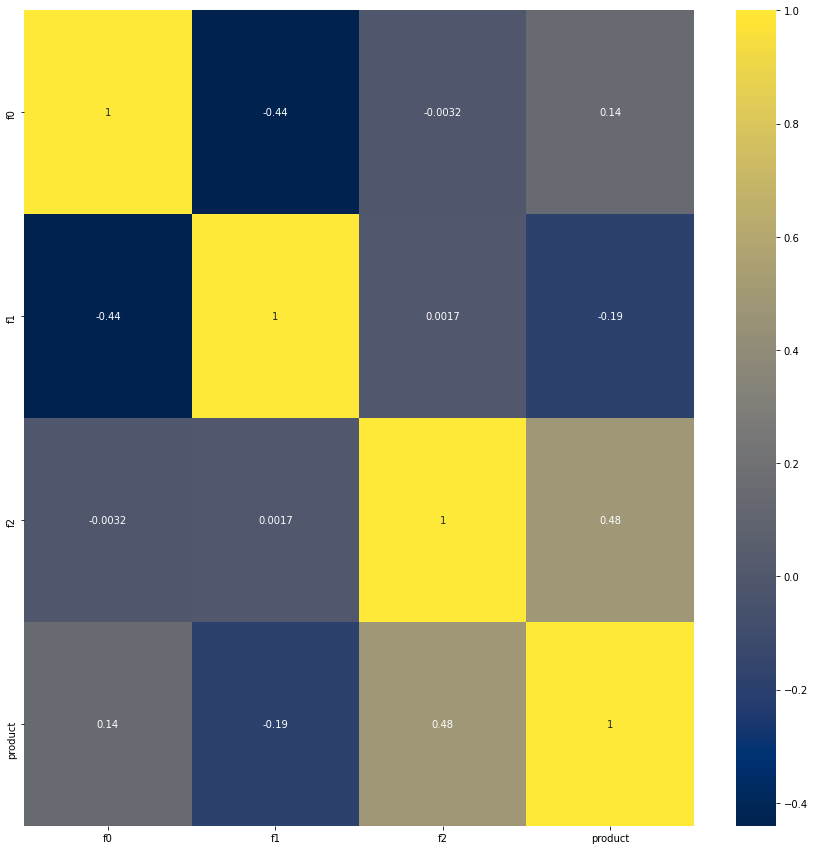

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df_geo1.corr(), annot=True, cmap='cividis',).legend = False

Мультиколлинеарности в данных не прослеживается

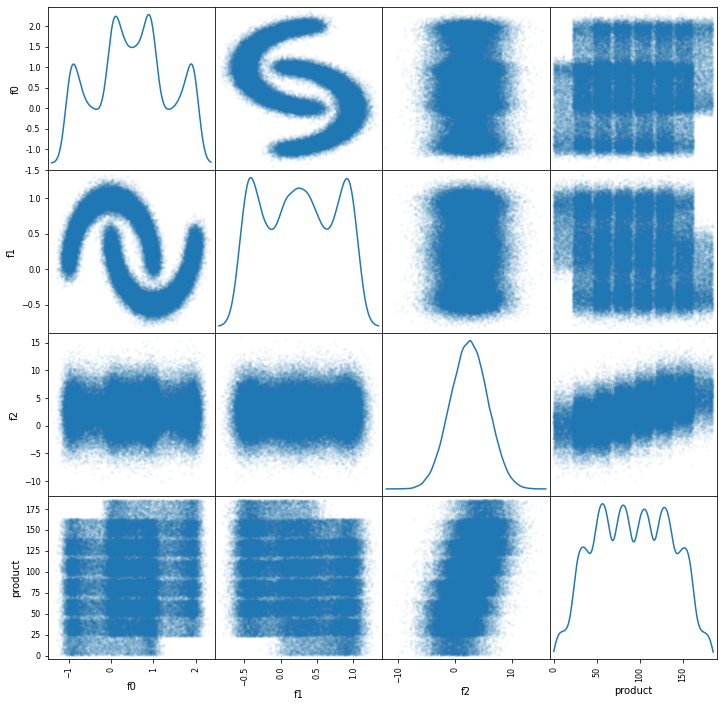

In [ ]:
corr_multi = df_geo1.pivot_table(index='id', values=df_geo1.columns[1:], aggfunc='mean')
sm = pd.plotting.scatter_matrix(corr_multi, figsize=(12, 12), diagonal='kde', alpha=0.05)

plt.show()

2-ой регион:

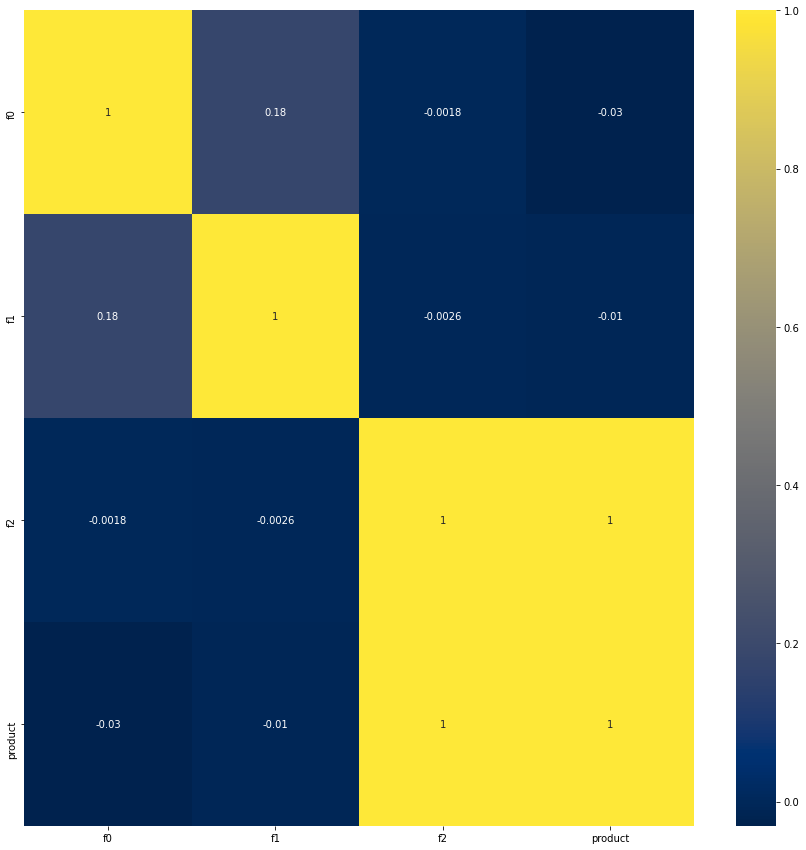

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df_geo2.corr(), annot=True, cmap='cividis',).legend = False

Наблюдаем максимальную корреляцию 'f2' с целевым признаком, похоже на утечку, но так как ничего о входных признаках неизвестно оставлю как есть

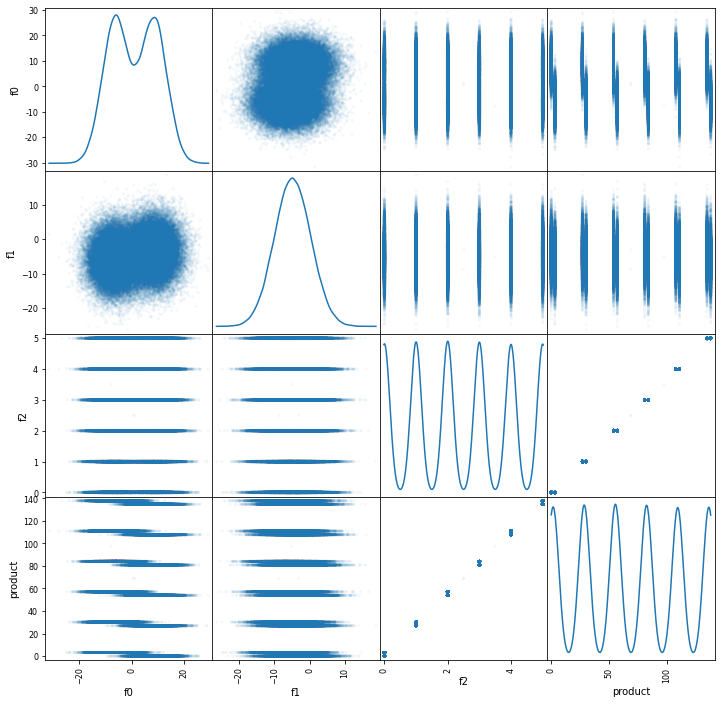

In [ ]:
corr_multi = df_geo2.pivot_table(index='id', values=df_geo2.columns[1:], aggfunc='mean')
sm = pd.plotting.scatter_matrix(corr_multi, figsize=(12, 12), diagonal='kde', alpha=0.05)

plt.show()

3-ий регион:

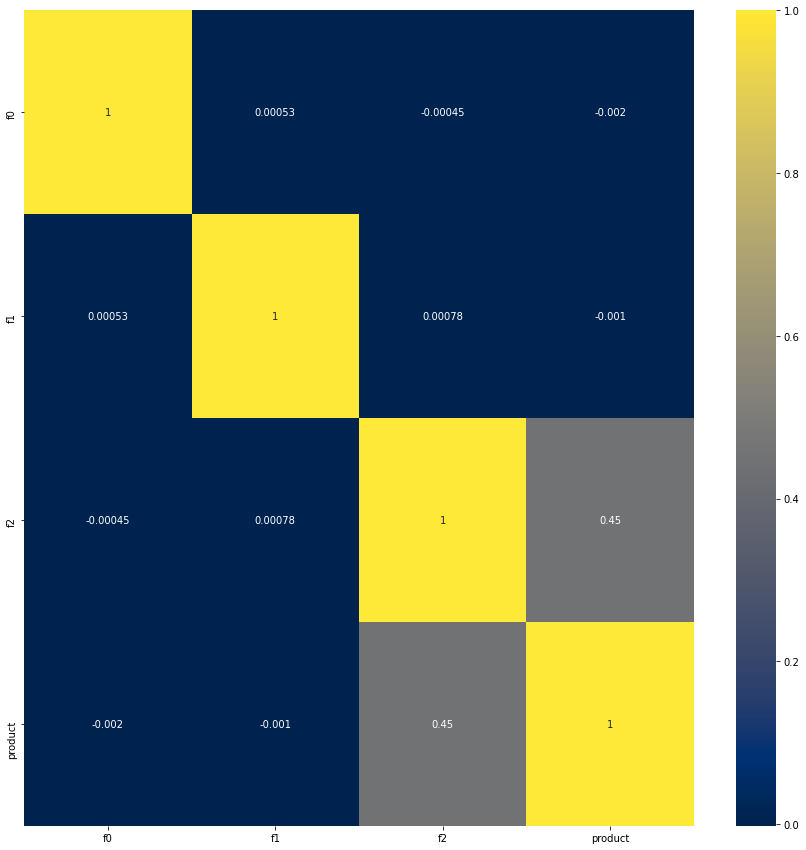

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df_geo3.corr(), annot=True, cmap='cividis',).legend = False

Мультиколлинеарности в данных не прослеживается

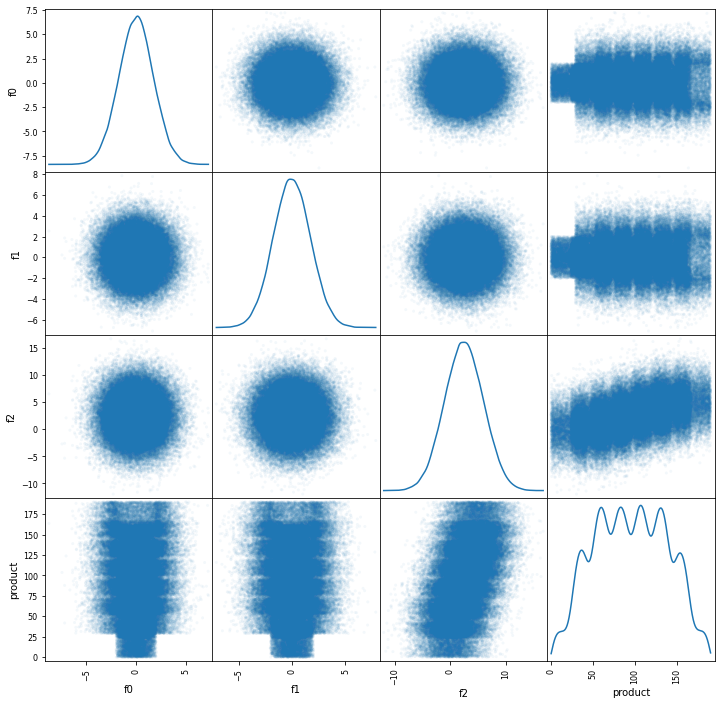

In [ ]:
corr_multi = df_geo3.pivot_table(index='id', values=df_geo3.columns[1:], aggfunc='mean')
sm = pd.plotting.scatter_matrix(corr_multi, figsize=(12, 12), diagonal='kde', alpha=0.05)

plt.show()

## Обучение и проверка модели

### 1-ый регион

Выделим 'фичи' и целевую переменную из фрейма, разделим фрейм на тренировочный и валидационный, сохраним для удобства названия входных признаков в 'num_columns'

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train1, X_test1, y_train1, y_test1 = train_test_split(
    df_geo1.drop(['product','id', 'product_cat'], axis=1),
    df_geo1['product'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE)

num_columns = ['f0', 'f1', 'f2']

Создаём пайплайн подготовки данных для дальнейшего перебора методов масштабирования

In [ ]:
data_preprocessor = ColumnTransformer(
    [
     ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

Задаем параметры для кросс-валидации и перебора моделей с гиперпараметрами

In [ ]:
param_grid = [

    # словарь для модели Ridge()
    {
        'models': [Ridge(random_state=42)],
        'models__alpha': [0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели ElasticNet()
    {
        'models': [ElasticNet(random_state=42)],
        'models__alpha': [0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

Подбирать лучшую модель будем по метрике коэффициента детерминации

In [ ]:
randomized_search1 = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    n_iter=10,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)
randomized_search1.fit(X_train1, y_train1)
print('Лучшая модель и её параметры:\n\n', randomized_search1.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search1.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  ['f0', 'f1', 'f2'])])),
                ('models', Ridge(alpha=2, random_state=42))])
Метрика лучшей модели на кросс-валидации: 0.2764686317959611


Сохраним результаты предсказания на валидации и реальные результаты в 'result_geo1'

In [ ]:
result_geo1 = pd.concat([y_test1.reset_index(drop=True), pd.Series(randomized_search1.best_estimator_.predict(X_test1))], axis=1)
result_geo1 = result_geo1.rename(columns={'product': 'true', 0 :'predict'})
result_geo1

,true,predict
0,122.073350,101.899654
1,48.738540,78.216674
2,131.338088,115.265802
3,88.327757,105.618095
4,36.959266,97.979918
...,...,...
24995,148.821520,105.075713
24996,123.454003,74.768494
24997,91.945213,82.543304
24998,149.295563,81.826965


Проведем анализ остатков у нашей модели:

In [ ]:
residuals_geo1 = result_geo1['true'] - result_geo1['predict']
residuals_geo1.head()

0    20.173696
1   -29.478134
2    16.072286
3   -17.290338
4   -61.020652
dtype: float64

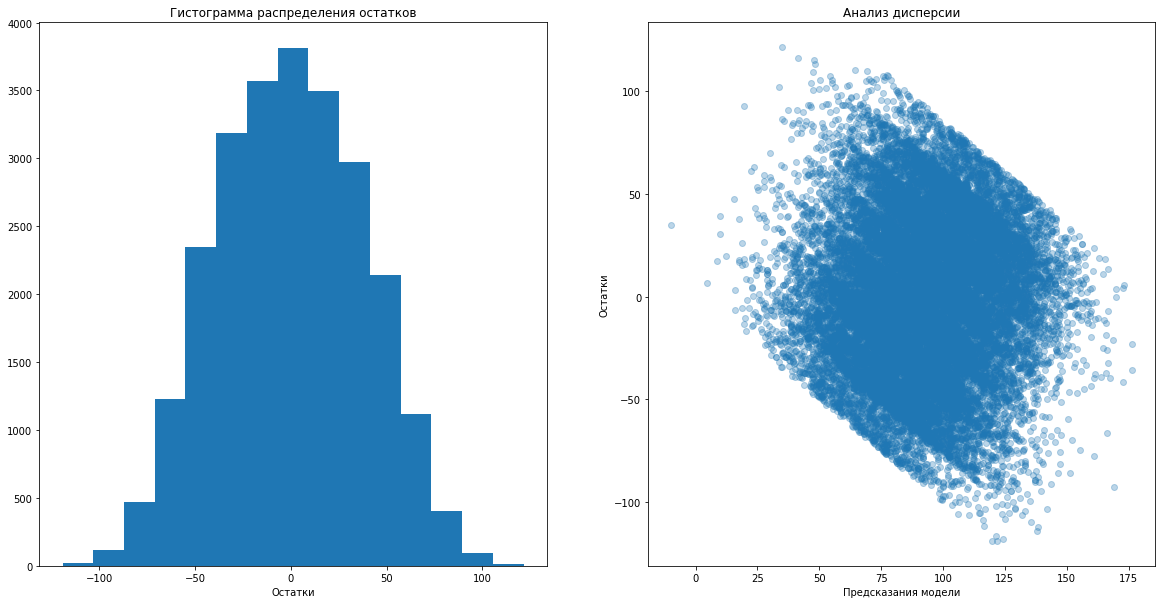

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].hist(residuals_geo1, bins=15)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=result_geo1['predict'], y=residuals_geo1, alpha=0.3)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Гистограмма остатков распределена нормально без смещений. На диаграмме рассеяния: при приближении к среднему значению целевого признака дисперсия увеличивается, а при удалении плавно уменьшается

Метрики качества модели:

In [ ]:
mse_1 = mean_squared_error(y_test1, result_geo1['predict'])
mse_1

1425.5602991385845

In [ ]:
rmse_1 = mean_squared_error(y_test1, result_geo1['predict'], squared=False)
rmse_1

37.756592790380125

In [ ]:
mae_1 = mean_absolute_error(y_test1, result_geo1['predict'])
mae_1

31.04768009193954

В среднем модель 'промахивается' на 31 тыс. баррелей продукта

In [ ]:
r2_1 = r2_score(y_test1, result_geo1['predict'])
r2_1

0.27282902401560416

Значение коэффициента детерминации 0.27 — модель предсказывает результат на 27.2 процента лучше чем среднее константное предсказание

### 2-ой регион

Выделим 'фичи' и целевую переменную из фрейма, разделим фрейм на тренировочный и валидационный, сохраним для удобства названия входных признаков в 'num_columns'

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    df_geo2.drop(['product','id', 'product_cat'], axis=1),
    df_geo2['product'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE)

num_columns = ['f0', 'f1', 'f2']

In [ ]:
randomized_search2 = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    n_iter=10,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)
randomized_search2.fit(X_train2, y_train2)
print('Лучшая модель и её параметры:\n\n', randomized_search2.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search2.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', Ridge(alpha=0.1, random_state=42))])
Метрика лучшей модели на кросс-валидации: 0.999624312446359


Сохраним результаты предсказания на валидации и реальные результаты в 'result_geo2'

In [ ]:
result_geo2 = pd.concat([y_test2.reset_index(drop=True), pd.Series(randomized_search2.best_estimator_.predict(X_test2))], axis=1)
result_geo2 = result_geo2.rename(columns={'product': 'true', 0 :'predict'})
result_geo2

,true,predict
0,0.000000,0.844828
1,53.906522,52.921632
2,134.766305,135.110296
3,107.813044,109.494809
4,0.000000,-0.047200
...,...,...
24995,107.813044,108.351547
24996,53.906522,53.604070
24997,26.953261,26.708790
24998,110.992147,109.823033


Проведем анализ остатков у нашей модели:

In [ ]:
residuals_geo2 = result_geo2['true'] - result_geo2['predict']
residuals_geo2.head()

0   -0.844828
1    0.984890
2   -0.343991
3   -1.681764
4    0.047200
dtype: float64

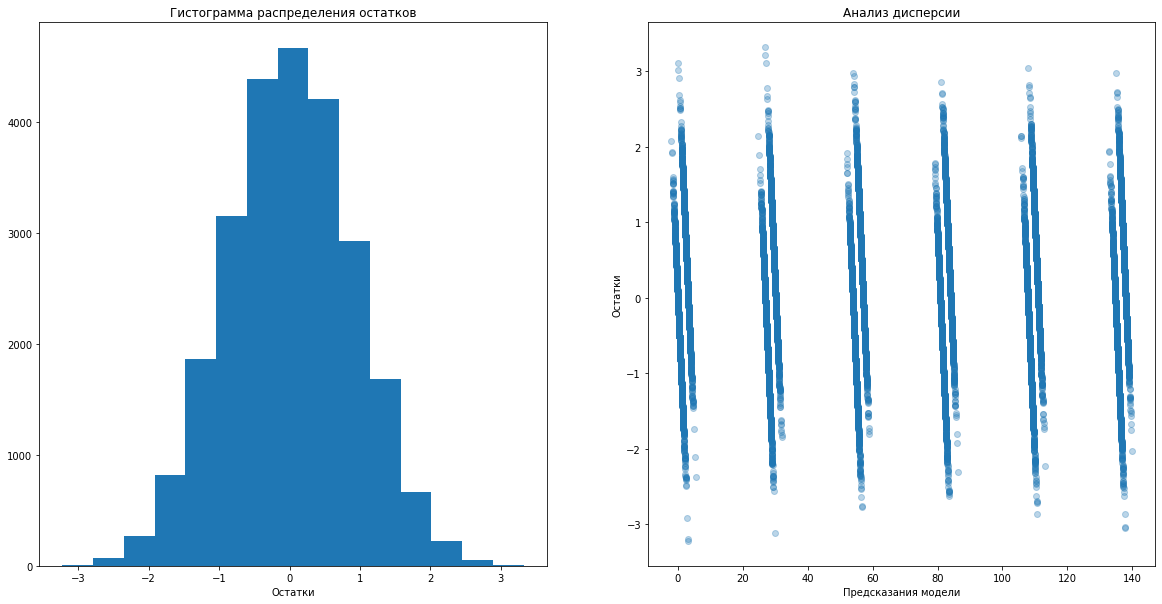

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].hist(residuals_geo2, bins=15)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=result_geo2['predict'], y=residuals_geo2, alpha=0.3)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Гистограмма остатков распределена нормально без смещений. На диаграмме рассеяния: дисперсия остатков небольшая в соотношении целевого признака (-3;3), предсказания расположены около 6 константных значений ~0, 30 ... 140

In [ ]:
mse_2 = mean_squared_error(y_test2, result_geo2['predict'])
mse_2

0.7925974674538288

In [ ]:
rmse_2 = mean_squared_error(y_test2, result_geo2['predict'], squared=False)
rmse_2

0.8902794322311556

In [ ]:
mae_2 = mean_absolute_error(y_test2, result_geo2['predict'])
mae_2

0.7170114334249829

В среднем модель 'промахивается' на 0.71 тыс. баррелей продукта

In [ ]:
r2_2 = r2_score(y_test2, result_geo2['predict'])
r2_2

0.9996245237635962

Значение коэффициента детерминации близко к единице — модель предсказывает результат на 99 процентов лучше чем среднее константное предсказание

### 3-ий регион

Выделим 'фичи' и целевую переменную из фрейма, разделим фрейм на тренировочный и валидационный, сохраним для удобства названия входных признаков в 'num_columns'

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train3, X_test3, y_train3, y_test3 = train_test_split(
    df_geo3.drop(['product','id', 'product_cat'], axis=1),
    df_geo3['product'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE)

num_columns = ['f0', 'f1', 'f2']

In [ ]:
randomized_search3 = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    n_iter=10,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)
randomized_search3.fit(X_train3, y_train3)
print('Лучшая модель и её параметры:\n\n', randomized_search3.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search3.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', Ridge(alpha=1, random_state=42))])
Метрика лучшей модели на кросс-валидации: 0.19948005199253796


Сохраним результаты предсказания на валидации и реальные результаты в 'result_geo3'

In [ ]:
result_geo3 = pd.concat([y_test3.reset_index(drop=True), pd.Series(randomized_search3.best_estimator_.predict(X_test3))], axis=1)
result_geo3 = result_geo3.rename(columns={'product': 'true', 0 :'predict'})
result_geo3

,true,predict
0,117.441301,98.301872
1,47.841249,101.592373
2,45.883483,52.449666
3,139.014608,109.921927
4,84.004276,72.412148
...,...,...
24995,40.797226,102.764065
24996,87.144239,93.431843
24997,52.039812,64.098802
24998,136.961454,83.764284


Проведем анализ остатков у нашей модели:

In [ ]:
residuals_geo3 = result_geo3['true'] - result_geo3['predict']
residuals_geo3.head()

0    19.139429
1   -53.751123
2    -6.566182
3    29.092680
4    11.592127
dtype: float64

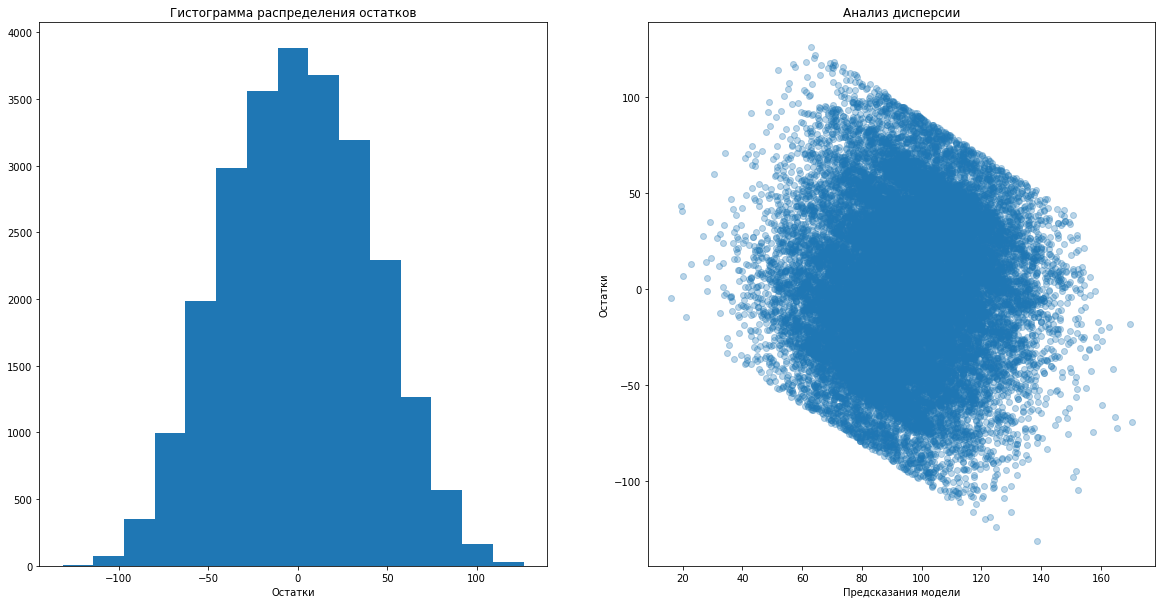

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].hist(residuals_geo3, bins=15)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=result_geo3['predict'], y=residuals_geo3, alpha=0.3)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Гистограмма остатков распределена нормально без смещений. На диаграмме рассеяния: при приближении к среднему значению целевого признака дисперсия увеличивается, а при удалении плавно уменьшается

In [ ]:
mse_3 = mean_squared_error(y_test3, result_geo3['predict'])
mse_3

1611.6910196121953

In [ ]:
rmse_3 = mean_squared_error(y_test3, result_geo3['predict'], squared=False)
rmse_3

40.14587176301189

In [ ]:
mae_3 = mean_absolute_error(y_test3, result_geo3['predict'])
mae_3

32.896974410367456

В среднем модель 'промахивается' на 32.89 тыс. баррелей продукта

In [ ]:
r2_3 = r2_score(y_test3, result_geo3['predict'])
r2_3

0.1963470817261076

Значение коэффициента детерминации 0.19 — модель показывает результат на 19.63 процента лучше чем среднее константное предсказание

## Подготовка к расчёту прибыли

### Cохранение ключевых значений для расчётов в отдельных переменных

Данные предсказаний и истинных значений сохранены в переменных 'result_geo' для каждого региона

In [ ]:
result_geo1.head()

,true,predict
0,122.073350,101.899654
1,48.738540,78.216674
2,131.338088,115.265802
3,88.327757,105.618095
4,36.959266,97.979918


In [ ]:
result_geo2.head()

,true,predict
0,0.000000,0.844828
1,53.906522,52.921632
2,134.766305,135.110296
3,107.813044,109.494809
4,0.000000,-0.047200


In [ ]:
result_geo3.head()

,true,predict
0,117.441301,98.301872
1,47.841249,101.592373
2,45.883483,52.449666
3,139.014608,109.921927
4,84.004276,72.412148


Сохраняем бюджет (переводим в тыс. рублей), кол-во скважин которые будем отбирать и цену одного барреля продукта в отдельные переменные

In [ ]:
budget = 10_000_000

In [ ]:
n_well = 200

In [ ]:
income_1_product = 450

### Расчет достаточного объёма сырья

Рассчитываем бюджет на одну скважину

In [ ]:
min_budget_1_well = budget/n_well
min_budget_1_well

50000.0

Сколько должно быть тыс. баррелей продукта в одной скважине для безубыточной работы предприятия

In [ ]:
min_product_1_well = min_budget_1_well/income_1_product
min_product_1_well

111.11111111111111

Взглянем на средние значения продукта одной скважины каждого региона

In [ ]:
df_geo1['product'].mean()

92.50000000000001

In [ ]:
df_geo2['product'].mean()

68.82500000000002

In [ ]:
df_geo3['product'].mean()

95.00000000000004

Исходя из средних значений продукта и если не отбирать лучшие скважины, выгоднее всего разрабатывать в 3-ем регионе. Хотя и сравнивая среднее значение продукта одной скважины 3-го региона с минимальным допустимым кол-вом продукта одной скважины для безубыточной работы вероятнее всего предприятие понесет убыток

## Расчёт прибыли

Добавим в предсказания из тестовой выборки 'id' для идентификации скважин после отбора 200 лучших, сохраним эти данные в 'df_pred_geo', общую прибыль на истинных значениях рассчитаем и сохраним в 'income_top_pred_geo'

### 1-ый регион

Собираем df_pred_geo1

In [ ]:
df_pred_geo1 = X_test1.merge(df_geo1, how='inner')
df_pred_geo1['predict'] = result_geo1['predict']
df_pred_geo1

,f0,f1,f2,id,product,product_cat,predict
0,0.599283,-0.557623,2.121187,7C6bA,122.073350,high,101.899654
1,0.739017,-0.463156,-1.347584,dVxsn,48.738540,low,78.216674
2,1.422743,-0.534917,3.718798,1Gm3l,131.338088,high,115.265802
3,1.580244,-0.238458,2.805149,Nzg1t,88.327757,medium,105.618095
4,0.918974,0.023961,2.598575,Z7b4F,36.959266,low,97.979918
...,...,...,...,...,...,...,...
24995,0.754647,-0.512213,2.610771,pXFCs,148.821520,high,105.075713
24996,-0.062056,0.516884,0.714446,tf6nq,123.454003,high,74.768494
24997,0.593769,-0.425260,-0.525017,pv8T0,91.945213,medium,82.543304
24998,0.198209,0.453940,1.497557,nol4A,149.295563,high,81.826965


Фильтруем предсказания, оставляя топ-200 лучших скважин

In [ ]:
df_top_pred_geo1 = df_pred_geo1[df_pred_geo1['predict'] >= min(sorted(df_pred_geo1['predict'], reverse=True)[:200])]
df_top_pred_geo1

,f0,f1,f2,id,product,product_cat,predict
148,1.022126,0.307006,12.061806,ScDC2,162.700106,high,156.735743
343,1.116517,-0.359230,9.488913,Ibn3i,150.934202,high,149.632674
439,0.756800,-0.347837,10.188113,ipkQR,163.748720,high,152.701793
457,0.896968,-0.498996,12.828118,kU92A,176.807828,high,172.801361
618,0.477511,-0.698480,9.247731,EasUV,155.571552,high,150.430667
...,...,...,...,...,...,...,...
24465,1.510779,-0.675865,9.326597,5WRwb,144.569489,high,154.588280
24497,1.549964,-0.250512,9.674414,h3B4k,150.132296,high,150.966815
24754,0.601360,-0.388962,10.463590,5obv7,146.190600,high,154.508828
24916,0.146916,0.151626,11.177326,GTUjp,124.442268,high,149.765099


Вычисляем общее количество продукта при разработке 200 лучших скважин 1-го региона

In [ ]:
product_top_true_geo1 = df_top_pred_geo1['product'].sum()
product_top_true_geo1

29686.9802543604

Рассчитываем общую прибыль при разработке 200 лучших скважин 1-го региона

In [ ]:
income_top_true_geo1 = product_top_true_geo1*income_1_product - budget
income_top_true_geo1

3359141.11446218

### 2-ой регион

Собираем df_pred_geo2

In [ ]:
df_pred_geo2 = X_test2.merge(df_geo2, how='inner')
df_pred_geo2['predict'] = result_geo2['predict']
df_pred_geo2

,f0,f1,f2,id,product,product_cat,predict
0,6.078076,0.084568,0.002957,fYVDK,0.000000,low,0.844828
1,16.462386,2.712946,1.993030,3SQcq,53.906522,medium,52.921632
2,7.051898,0.766983,4.990194,hQ1gJ,134.766305,high,135.110296
3,-0.240045,-0.380804,3.999693,Y4vux,107.813044,high,109.494809
4,13.350111,-8.558281,0.002010,H1NUw,0.000000,low,-0.047200
...,...,...,...,...,...,...,...
24995,8.141417,-0.832158,4.001976,Vn3pL,107.813044,high,108.351547
24996,16.601751,-8.141232,2.010371,zZe7H,53.906522,medium,53.604070
24997,14.674777,-5.633890,1.004171,iefIy,26.953261,low,26.708790
24998,-1.381118,-5.464254,4.001648,CFT5B,110.992147,high,109.823033


Фильтруем предсказания, оставляя топ-200 лучших скважин

In [ ]:
df_top_pred_geo2 = df_pred_geo2[df_pred_geo2['predict'] >= min(sorted(df_pred_geo2['predict'], reverse=True)[:200])]
df_top_pred_geo2

,f0,f1,f2,id,product,product_cat,predict
692,-11.031973,-14.808719,5.005709,O7fPk,137.945408,high,138.486604
787,-16.143676,-9.323243,5.004794,IG3a3,137.945408,high,139.083804
856,-12.140233,-13.762742,5.005960,G8OaD,137.945408,high,138.631305
1085,-12.779071,-11.266704,5.001701,AnAeg,137.945408,high,138.555004
1100,-12.983675,-9.730622,5.003273,Q26h0,137.945408,high,138.593711
...,...,...,...,...,...,...,...
23930,-17.139363,-1.581876,5.003078,X7qdm,137.945408,high,139.014077
23985,-13.103006,-11.629729,4.998430,WV78y,137.945408,high,138.521649
24141,-15.344965,-2.735525,4.999584,w6b1j,137.945408,high,138.684879
24656,-13.272550,-8.167790,5.002878,FR6Rx,137.945408,high,138.591076


Вычисляем общее количество продукта при разработке 200 лучших скважин 2-го региона

In [ ]:
product_top_true_geo2 = df_top_pred_geo2['product'].sum()
product_top_true_geo2

27589.081548181137

Рассчитываем общую прибыль при разработке 200 лучших скважин 2-го региона

In [ ]:
income_top_true_geo2 = product_top_true_geo2*income_1_product - budget
income_top_true_geo2

2415086.6966815125

### 3-ий регион

Собираем df_pred_geo3

In [ ]:
df_pred_geo3 = X_test3.merge(df_geo3, how='inner')
df_pred_geo3['predict'] = result_geo3['predict']
df_pred_geo3

,f0,f1,f2,id,product,product_cat,predict
0,2.111118,-1.679773,3.112240,sPjbT,117.441301,medium,98.301872
1,0.734759,0.747788,3.670879,1u4uo,47.841249,low,101.592373
2,-2.513109,0.844631,-4.922889,kZ6HO,45.883483,low,52.449666
3,-2.035301,-1.522988,5.072839,gCZGK,139.014608,high,109.921927
4,2.744145,1.429952,-1.372661,rqJHx,84.004276,medium,72.412148
...,...,...,...,...,...,...,...
24995,-1.532677,0.365315,3.840436,hMnQH,40.797226,low,102.764065
24996,1.381244,1.168552,2.262261,KGq37,87.144239,medium,93.431843
24997,2.902487,0.839203,-2.817721,CKCjb,52.039812,low,64.098802
24998,0.942093,-1.424641,0.567559,ANcQx,136.961454,high,83.764284


Фильтруем предсказания, оставляя топ-200 лучших скважин

In [ ]:
df_top_pred_geo3 = df_pred_geo3[df_pred_geo3['predict'] >= min(sorted(df_pred_geo3['predict'], reverse=True)[:200])]
df_top_pred_geo3

,f0,f1,f2,id,product,product_cat,predict
267,0.580305,0.908355,11.180321,Yyn3R,108.664111,medium,144.782502
367,-0.850470,1.593454,11.577142,r5aWJ,151.723046,high,147.174054
370,-2.121689,-1.022273,11.628019,VqMwQ,115.174488,medium,147.614021
380,-3.586495,1.001005,11.663614,3fGUF,183.541539,high,147.910687
502,-0.204332,0.871921,11.726030,fxJK9,149.357120,high,147.986946
...,...,...,...,...,...,...,...
24576,-0.663384,1.780212,11.548959,TqFVk,103.530769,medium,146.993367
24690,-1.050331,0.621284,13.580233,pL37u,128.530947,high,158.723764
24763,-3.221371,0.290302,11.276394,uLLSq,172.582788,high,145.664418
24884,1.147994,1.723711,12.398069,Lpu1Z,151.126557,high,151.724221


Вычисляем общее количество продукта при разработке 200 лучших скважин 3-го региона

In [ ]:
product_top_true_geo3 = df_top_pred_geo3['product'].sum()
product_top_true_geo3

27996.82613194247

Рассчитываем общую прибыль при разработке 200 лучших скважин 3-го региона

In [ ]:
income_top_true_geo3 = product_top_true_geo3*income_1_product - budget
income_top_true_geo3

2598571.759374112

Исходя из расчета общей прибыли при разработке 200 лучших скважин региона, самым выгодным выходит 1-ый регион, ~3359141.11 тыс. рублей прибыли. Это максимально возможная прибыль если бы мы могли разведовать все возможные скважины в регионе

## Риски и доверительный интервал прибыли при помощи Bootstrap

Применим технику Bootstrap с 1000 выборок, найдем распределение прибыли и вычислим 95% доверительный интервал

### 1-ый регион

In [ ]:
state = np.random.RandomState(42)

values = []
for i in range(1000):
    subsample = df_pred_geo1['predict'].sample(frac=500/len(df_pred_geo1), replace=True, random_state=state)
    subsample = pd.Series(sorted(subsample, reverse=True)[:200])

    values.append(subsample.mean())

values = pd.Series(values)*income_1_product

lower = values.quantile(0.025)
upper = values.quantile(0.975)

print('Нижний порог доверительного интервала среднего дохода с одной скважины(тыс. рублей):', lower)
print('Верхний порог доверительного интервала среднего дохода с одной скважины(тыс. рублей):', upper)
print('Средний доход с одной скважины(тыс. рублей):', values.mean())

Нижний порог доверительного интервала средней прибыли с одной скважины(тыс. рублей): 50527.00221139645
Верхний порог доверительного интервала средней прибыли с одной скважины(тыс. рублей): 52776.165178359195
Средняя прибыль с одной скважины(тыс. рублей) составляет: 51657.28298514543


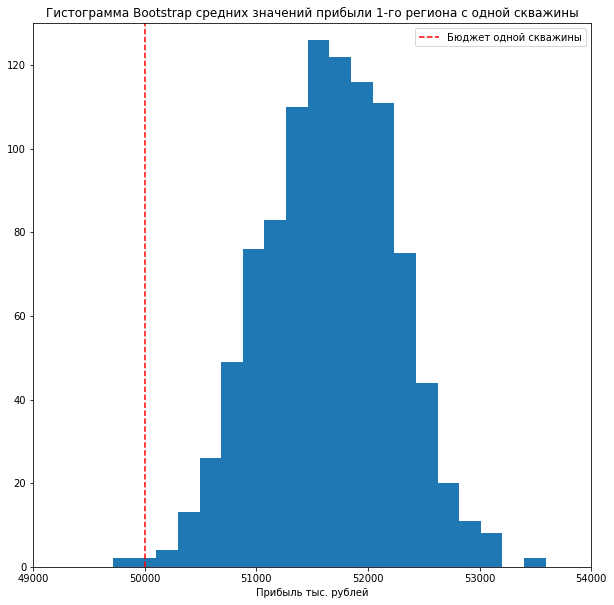

In [ ]:
plt.subplots(figsize=(10,10))
plt.hist(values, bins=20)
plt.title('Гистограмма Bootstrap средних значений дохода 1-го региона с одной скважины')
plt.xlabel('Прибыль тыс. рублей')
plt.plot([min_budget_1_well, min_budget_1_well], [0, 150], "r--", label="Бюджет одной скважины")
plt.legend(loc="best")
plt.xlim(49000, 54000)
plt.ylim(0, 130)

plt.show()

In [ ]:
risk_of_loss1 = ((values < min_budget_1_well).sum()/len(values)) * 100
print('Риск убытка при разработке 1-го региона составляет:', risk_of_loss1, '%')

Риск убытка при разработке 1-го региона составляет: 0.3 %


### 2-ой регион

In [ ]:
values = []
for i in range(1000):
    subsample = df_pred_geo2['predict'].sample(frac=500/len(df_pred_geo2), replace=True, random_state=state)
    subsample = pd.Series(sorted(subsample, reverse=True)[:200])

    values.append(subsample.mean())

values = pd.Series(values)*income_1_product

lower = values.quantile(0.025)
upper = values.quantile(0.975)

print('Нижний порог доверительного интервала среднего дохода с одной скважины(тыс. рублей):', lower)
print('Верхний порог доверительного интервала среднего дохода с одной скважины(тыс. рублей):', upper)
print('Средний доход с одной скважины(тыс. рублей):', values.mean())

Нижний порог доверительного интервала средней прибыли с одной скважины(тыс. рублей): 50258.31514436833
Верхний порог доверительного интервала средней прибыли с одной скважины(тыс. рублей): 54188.80882152791
Средняя прибыль с одной скважины(тыс. рублей) составляет: 52252.37874239098


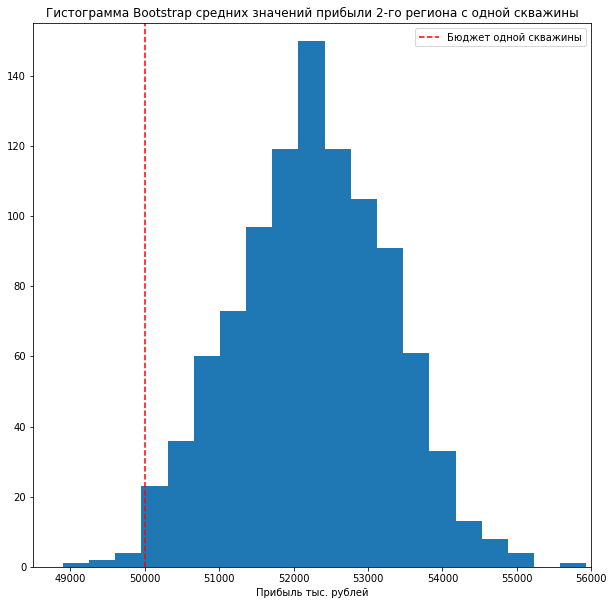

In [ ]:
plt.subplots(figsize=(10,10))
plt.hist(values, bins=20)
plt.title('Гистограмма Bootstrap средних значений дохода 2-го региона с одной скважины')
plt.xlabel('Прибыль тыс. рублей')
plt.plot([min_budget_1_well, min_budget_1_well], [0, 160], "r--", label="Бюджет одной скважины")
plt.legend(loc="best")
plt.xlim(48500, 56000)
plt.ylim(0, 155)

plt.show()

In [ ]:
risk_of_loss2 = ((values < min_budget_1_well).sum()/len(values)) * 100
print('Риск убытка при разработке 2-го региона составляет:', risk_of_loss2, '%')

Риск убытка при разработке 2-го региона составляет: 0.8 %


### 3-ий регион

In [ ]:
values = []
for i in range(1000):
    subsample = df_pred_geo3['predict'].sample(frac=500/len(df_pred_geo3), replace=True, random_state=state)
    subsample = pd.Series(sorted(subsample, reverse=True)[:200])

    values.append(subsample.mean())

values = pd.Series(values)*income_1_product

lower = values.quantile(0.025)
upper = values.quantile(0.975)

print('Нижний порог доверительного интервала среднего дохода с одной скважины(тыс. рублей):', lower)
print('Верхний порог доверительного интервала среднего дохода с одной скважины(тыс. рублей):', upper)
print('Средний доход с одной скважины(тыс. рублей):', values.mean())

Нижний порог доверительного интервала средней прибыли с одной скважины(тыс. рублей): 50300.8850122289
Верхний порог доверительного интервала средней прибыли с одной скважины(тыс. рублей): 52278.872050659455
Средняя прибыль с одной скважины(тыс. рублей) составляет: 51344.49528646307


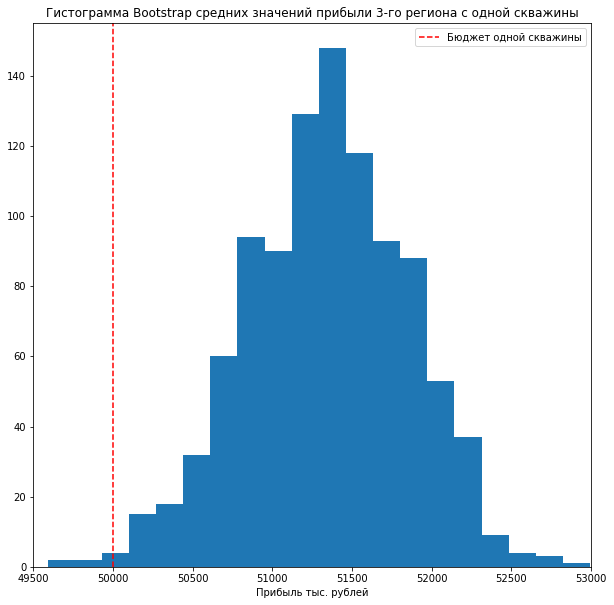

In [ ]:
plt.subplots(figsize=(10,10))
plt.hist(values, bins=20)
plt.title('Гистограмма Bootstrap средних значений дохода 3-го региона с одной скважины')
plt.xlabel('Прибыль тыс. рублей')
plt.plot([min_budget_1_well, min_budget_1_well], [0, 160], "r--", label="Бюджет одной скважины")
plt.legend(loc="best")
plt.xlim(49500, 53000)
plt.ylim(0, 155)

plt.show()

In [ ]:
risk_of_loss3 = ((values < min_budget_1_well).sum()/len(values)) * 100
print('Риск убытка при разработке 3-го региона составляет:', risk_of_loss3, '%')

Риск убытка при разработке 3-го региона составляет: 0.5 %


## Общий вывод

В проделанной работе есть промежуточные выводы, в общем выводе я бы хотел обобщить их и подвести итог по работе с данными

<h3>Загрузка и подготовка данных</h3>

<h4>Загрузка данных</h4>

**Данные представленны в 3 файлах:**

Во всех таблицах (каждая отдельный регион) 100000 строк:

1 колонка типа object: id;

3 колонки типа float: f0, f1, f2, product

<h4>Предобработка данных</h4>

Типы данных в фреймах представленны корректно

Была проведена проверка на наличе пропусков в данных, пропусков не обнаружилось

Явных дубликатов в данных не обнаружилось

Проведена проверка дубликатов исключая 'id', нашлись одни и те же скважины но с разными параметрами, удаление не производил

<h4>Исследовательский анализ данных</h4>

Проведено исследование кол-ых признаков:

Выделенны категории из целевого признака, для цветовой маркировки на гистограммах

**1-ый регион:**

-'f0' напоминает нормальное распределение с 'пиками' ближе к крайним значениям разброс варьируется от -1.4 до 2.36, в среднем 0.5

Цветовой маркер целевого признака указывает что 'f0' чуть меньше у скважины с малым содержанием продукта

Аномальных значений не наблюдаем

-'f1' напоминает нормальное распределение разброс варьируется от -0.8 до 1.34, в среднем 0.25

Цветовой маркер целевого признака указывает что 'f1' чуть больше у скважины с малым содержанием продукта

Аномальных значений не наблюдаем

-'f2' напоминает нормальное распределение разброс варьируется от -12.08 до 16, в среднем 2.5

Цветовой маркер целевого признака указывает что 'f2' больше у скважины с большим содержанием продукта

Наблюдаем слегка выбивающиеся значения с обоих сторон распределения

-'product'(объём запасов в скважине, целевой признак) напоминает нормальное распределение разброс продукта варьируется от 0 до 185, в среднем 92.5

Аномальных значений не наблюдаем

**2-ой регион:**

-'f0' напоминает нормальное распределение разброс варьируется от -31.6 до 29.42, в среднем 1.14

Цветовой маркер целевого признака случаен

Аномальных значений не наблюдаем

-'f1' напоминает нормальное распределение разброс варьируется от -26.35 до 18.73, в среднем -4.79

Цветовой маркер целевого признака случаен

Наблюдаем слегка выбивающиеся значения с обоих сторон распределения

-'f2' имеет вид распределения Бернули с 6-ю вариантами событий, большенство наблюдений расположенны около целых значений что аномально, разброс варьируется от -0.01 до 5.01 в среднем 2.49

Цветовой маркер целевого признака указывает что 'f2' больше у скважины с большим содержанием продукта

Аномальных значений не наблюдаем

-'product'(объём запасов в скважине, целевой признак) имеет одентичный вид с 'f2', разброс варьируется от 0 до 137.9 в среднем 68.82

Аномальных значений не наблюдаем

**3-ий регион**

-'f0' напоминает нормальное распределение разброс варьируется от -8.76 до 7.23, в среднем 0.002

Цветовой маркер целевого признака случаен

Наблюдаем слегка выбивающиеся значения с обоих сторон распределения

-'f1' напоминает нормальное распределение разброс варьируется от -7.08 до 7.84, в среднем -0.002

Цветовой маркер целевого признака случаен

Наблюдаем слегка выбивающиеся значения с обоих сторон распределения

-'f2' напоминает нормальное распределение разброс варьируется от -11.97 до 16.73, в среднем 2.49

Цветовой маркер целевого признака указывает что 'f2' больше у скважины с большим содержанием продукта

Наблюдаем слегка выбивающиеся значения с обоих сторон распределения

-'product'(объём запасов в скважине, целевой признак) напоминает нормальное распределение разброс варьируется от 0 до 190.02, в среднем 95

Аномальных значений не наблюдаем

<h4>Корреляционный анализ</h4>

Построен "хитмап" по матрице корреляций Пирсона,  для отслеживания связи признаков с целевой переменной и для отслеживания мультиколлинеарности, мультиколлинеарности в данных не прослеживается

Во 2-ом регионе наблюдается максимальная корреляция'f2' с целевым признаком, похоже на утечку, оставленно как есть

<h3>Обучение и проверка модели</h3>

Данные разбиты на обучающую и валидационную в соотношении 75:25

Был проведен перебор линейных моделей и их гиперпараметров(Ridge, ElasticNet, LinearRegression) с предобработкой данных в пайплайне с разными методами масштабирования(StandardScaler, MinMaxScaler, 'passthrough') при помощи RandomizedSearchCV на метрике r2.

**1-ый регион**

Лучшей моделью на кросс-валидации для 1-го региона получилась модель Ridge(alpha=2, random_state=42) без масштабирования кол-ых признаков 'passthrough'

Результаты предсказания на валидации и реальные результаты сохраненны в 'result_geo1'

На анализе остатков: Гистограмма остатков распределена нормально без смещений. На диаграмме рассеяния: при приближении к среднему значению целевого признака дисперсия увеличивается, а при удалении плавно уменьшается

Метрики качества модели:

mse = 1425.56

rmse = 37.75

mae = 31.04

В среднем модель 'промахивается' на 31 тыс. баррелей продукта

r2 = 0.27

Значение коэффициента детерминации 0.27 — модель предсказывает результат на 27.2 процента лучше чем среднее константное предсказание

**2-ой регион**

Лучшей моделью на кросс-валидации для 2-го региона получилась модель Ridge(alpha=0.1, random_state=42) с масштабированием кол-ых признаков StandardScaler()

Результаты предсказания на валидации и реальные результаты сохраненны в 'result_geo2'

На анализе остатков: Гистограмма остатков распределена нормально без смещений. На диаграмме рассеяния: дисперсия остатков небольшая в соотношении целевого признака (-3;3), предсказания расположены около 6 константных значений ~0, 30 ... 140

Метрики качества модели:

mse = 0.79

rmse = 0.89

mae = 0.71

В среднем модель 'промахивается' на 0.71 тыс. баррелей продукта

r2 = 0.99

Значение коэффициента детерминации близко к единице — модель предсказывает результат на 99 процентов лучше чем среднее константное предсказание

**3-ий регион**

Лучшей моделью на кросс-валидации для 3-го региона получилась модель Ridge(alpha=1, random_state=42) с масштабированием кол-ых признаков StandardScaler()

Результаты предсказания на валидации и реальные результаты сохраненны в 'result_geo3'

На анализе остатков: Гистограмма остатков распределена нормально без смещений. На диаграмме рассеяния: при приближении к среднему значению целевого признака дисперсия увеличивается, а при удалении плавно уменьшается

Метрики качества модели:

mse = 1611.69

rmse = 40.14

mae = 32.89

В среднем модель 'промахивается' на 32.89 тыс. баррелей продукта

r2 = 0.19

Значение коэффициента детерминации 0.19 — модель показывает результат на 19.63 процента лучше чем среднее константное предсказание

<h3>Подготовка к расчёту прибыли</h3>

<h4>Cохранение ключевых значений для расчётов в отдельных переменных</h4>

Данные предсказаний и истинных значений сохранены в переменных 'result_geo' для каждого региона

Данные бюджета (переводим в тыс. рублей), кол-во скважин которые будем отбирать и цену одного барреля продукта солхраненны в отдельные переменные: budget, n_well, income_1_product

<h4>Расчет достаточного объёма сырья</h4>

**Произведен рассчет:**

-Бюджета на одну скважину, сохранен в min_budget_1_well

-Сколько должно быть тыс. баррелей продукта в одной скважине для безубыточной работы предприятия, сохранен в min_product_1_well

Исходя из средних значений продукта и если не отбирать лучшие скважины, выгоднее всего разрабатывать в 3-ем регионе. Хотя и сравнивая среднее значение продукта одной скважины 3-го региона с минимальным допустимым кол-вом продукта одной скважины для безубыточной работы вероятнее всего предприятие понесет убыток

<h3>Расчёт прибыли</h3>

Добавленны в предсказания из тестовой выборки 'id' для идентификации скважин после отбора 200 лучших, эти данные сохраненны в 'df_pred_geo' для каждого региона

Для каждого регионна были отобранны 200 лучших скважин по максимальному содержанию продукта в скважине, эти данные сохраненны в 'df_top_pred_geo' для каждого региона

Произведен рассчет общего количества продукта истинных значений при разработке 200 лучших скважин каждого региона, данные сохраненны в 'product_top_true_geo' для каждого региона

Произведен рассчет общей прибыли для каждого региона при разработке 200 лучших скважин, данные сохраненны в 'income_top_true_geo' для каждого региона

Исходя из расчета общей прибыли при разработке 200 лучших скважин региона, самым выгодным выходит 1-ый регион, ~3359141.11 тыс. рублей прибыли. Это максимально возможная прибыль если бы мы могли разведовать все возможные скважины в регионе

<h3>Риски и доверительный интервал прибыли при помощи Bootstrap</h3>

Применена техника Bootstrap с 1000 выборок, найденны распределения прибыли и рассчитан 95% доверительный интервал для каждого региона

**1-ый регион**

Нижний порог доверительного интервала среднего дохода с одной скважины(тыс. рублей): 50527

Верхний порог доверительного интервала среднего дохода с одной скважины(тыс. рублей): 52776

Средний доход с одной скважины(тыс. рублей): 51657

Риск убытка составляет: 0.3%

**2-ой регион**

Нижний порог доверительного интервала среднего дохода с одной скважины(тыс. рублей): 50258

Верхний порог доверительного интервала среднего дохода с одной скважины(тыс. рублей): 54188

Средний доход с одной скважины(тыс. рублей): 52252

Риск убытка составляет: 0.8%

**3-ий регион**

Нижний порог доверительного интервала среднего дохода с одной скважины(тыс. рублей): 50300

Верхний порог доверительного интервала среднего дохода с одной скважины(тыс. рублей): 52278

Средний доход с одной скважины(тыс. рублей): 51344

Риск убытка составляет: 0.5%

<h3>Итог</h3>

Исходя из вышесказанного для разработки 200 скважин рекомендуется 1-ый регион если преследовать цель минимизации рисков т.к. он является самым надежным из всех регионов, риск убытка 0.3% при среднем доходе 51657 тыс. рублей с одной скважины. Если же целью стоит максимизация дохода то следует обратить внимание на 2-ой регион, там средний доход с одной скважины 52252 тыс. рублей, но и риск убытка уже выше и сотавляет 0.8%